<h1> Task 1 - Setting the baseline <h1>

<h2> Task 1.1 - Data preparation and validation pipeline <h2>

<h3> Import librarys <h3>

In [2]:
import matplotlib.pyplot as plt                        # Library for plotting graphs and visualizations
import numpy as np                                     # Library for numerical computing (arrays, math functions)
import pandas as pd                                    # Library for handling datasets (tables, CSVs, DataFrames)
from sklearn.metrics import mean_squared_error , root_mean_squared_error  # Function to evaluate model performance using MSE
from sklearn.model_selection import train_test_split   # Utility to split dataset into training and testing sets
from sklearn.preprocessing import StandardScaler       # Tool to normalize/standardize features
from sklearn.preprocessing import PolynomialFeatures   # Generates polynomial features for non-linear regression
from sklearn.pipeline import make_pipeline             # Builds pipelines that chain preprocessing + model steps
from sklearn.linear_model import LinearRegression      # Ordinary least squares linear regression model
from sklearn.linear_model import Ridge, RidgeCV        # Ridge regression (L2 regularization) and Ridge with cross-validation
from sklearn.compose import ColumnTransformer          # Apply transformations to specific columns of the dataset
from sklearn.preprocessing import FunctionTransformer  # Apply custom functions to transform data
from sklearn.neighbors import KNeighborsRegressor      # k-Nearest Neighbors regression model
from sklearn.multioutput import MultiOutputRegressor   # Extend regressors to multi-output problems
import math                                            # Python built-in math library
import time                                            # Python built-in library to measure execution time
import seaborn as sns                                  #Statistical data visualization                           
import os                                              #Python built-in library for operating system interactions
import missingno as msno                               #Library for visualizing missing data
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score, cross_validate #Cross-validation utilities


<h3> Missing data visualization <h3>

<Axes: >

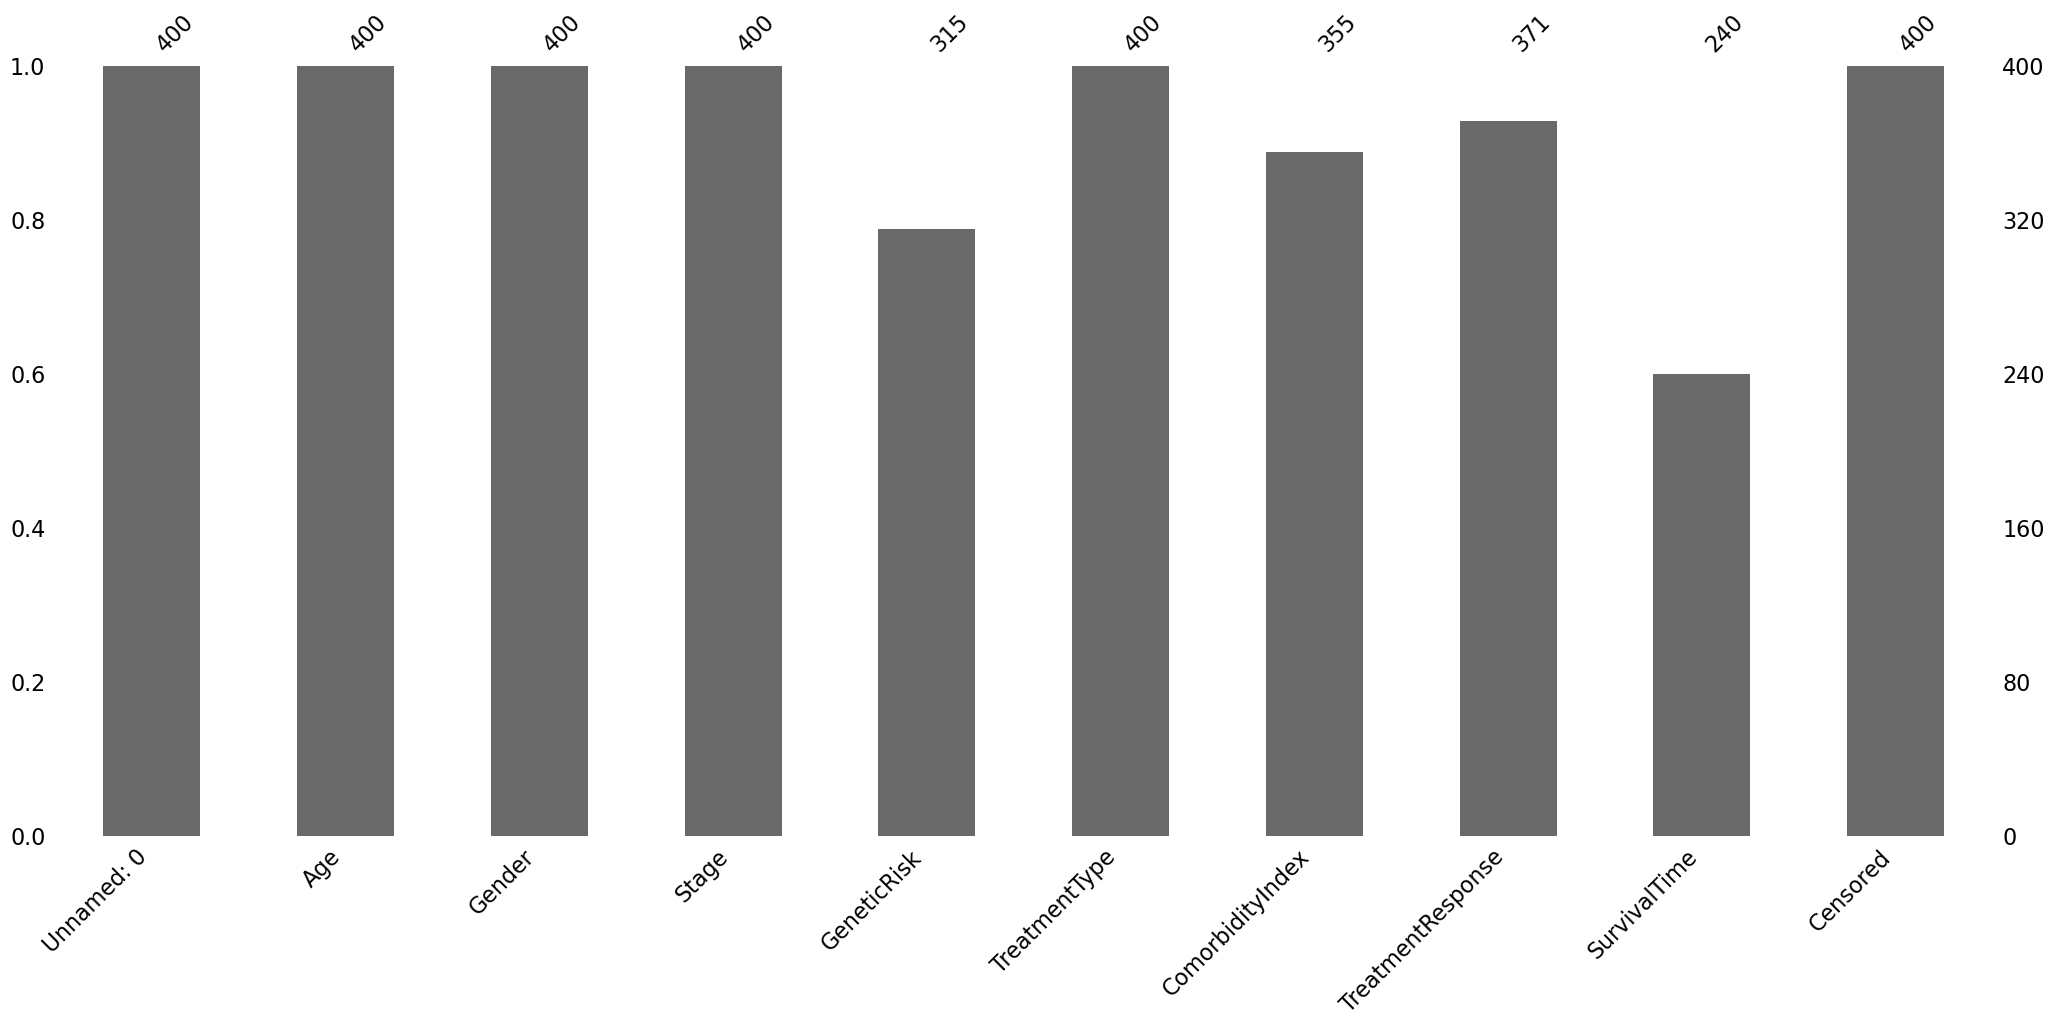

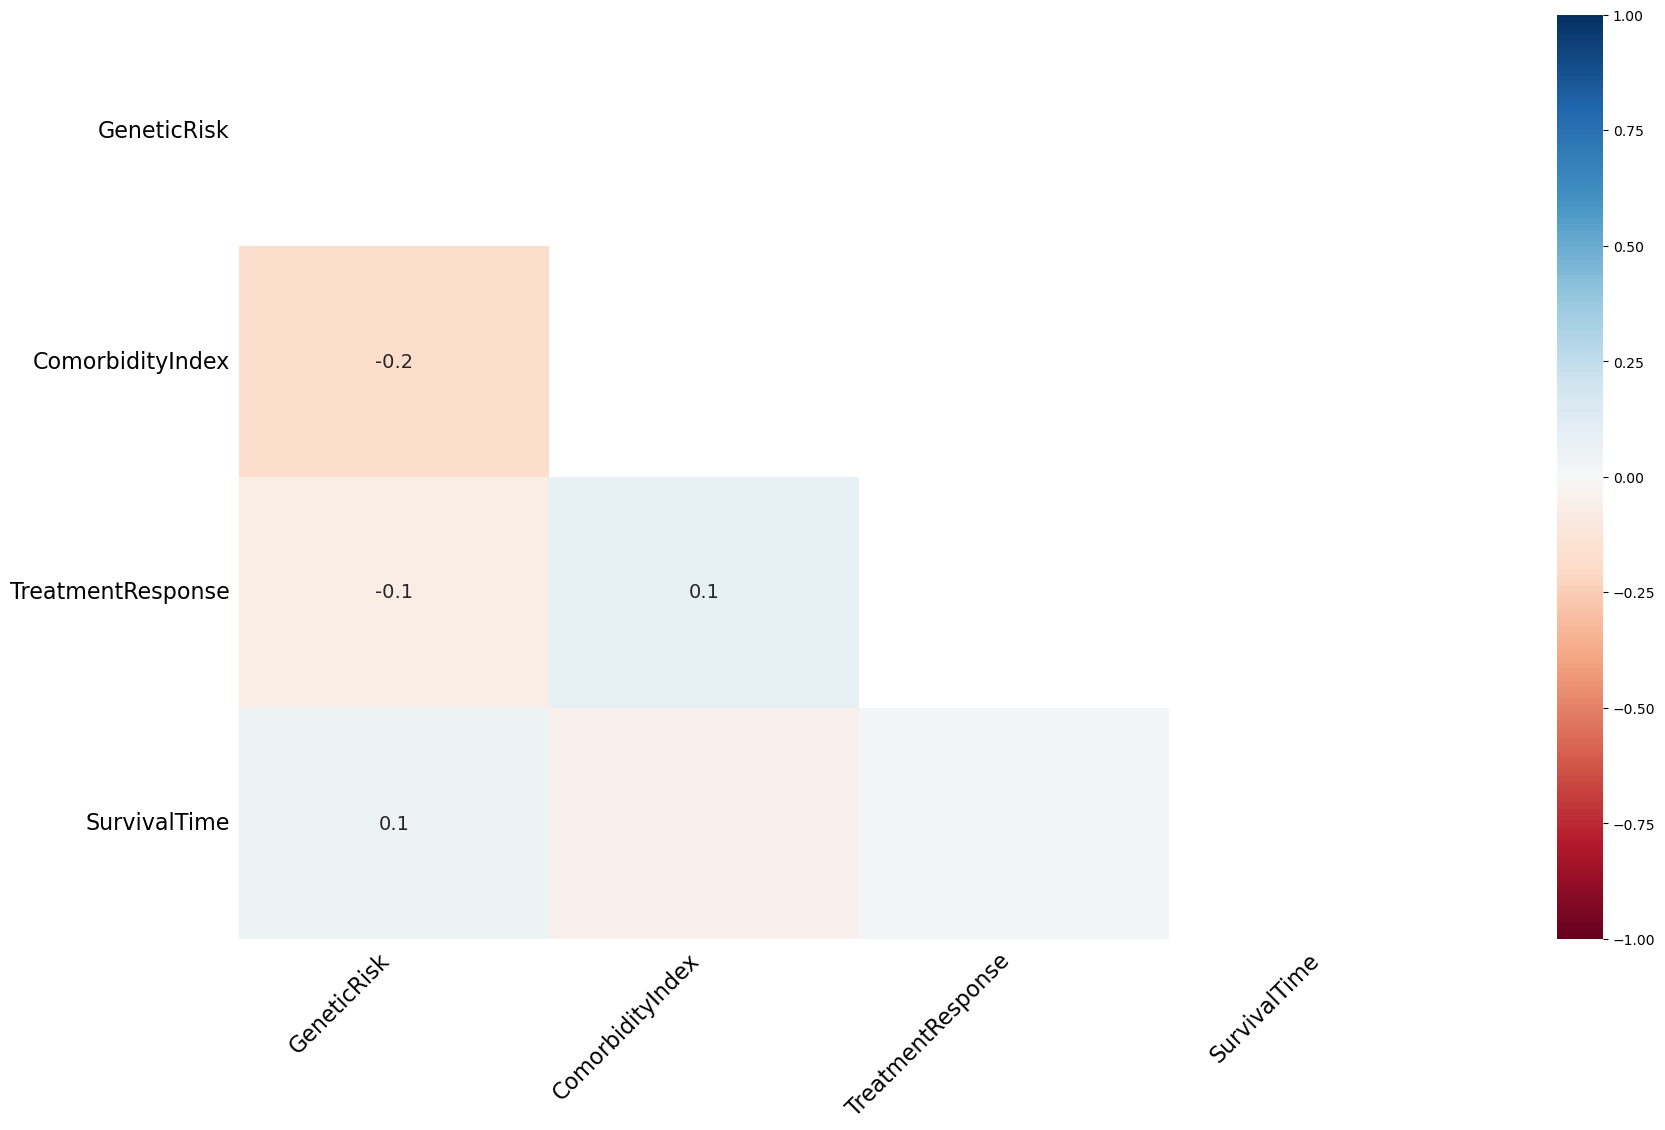

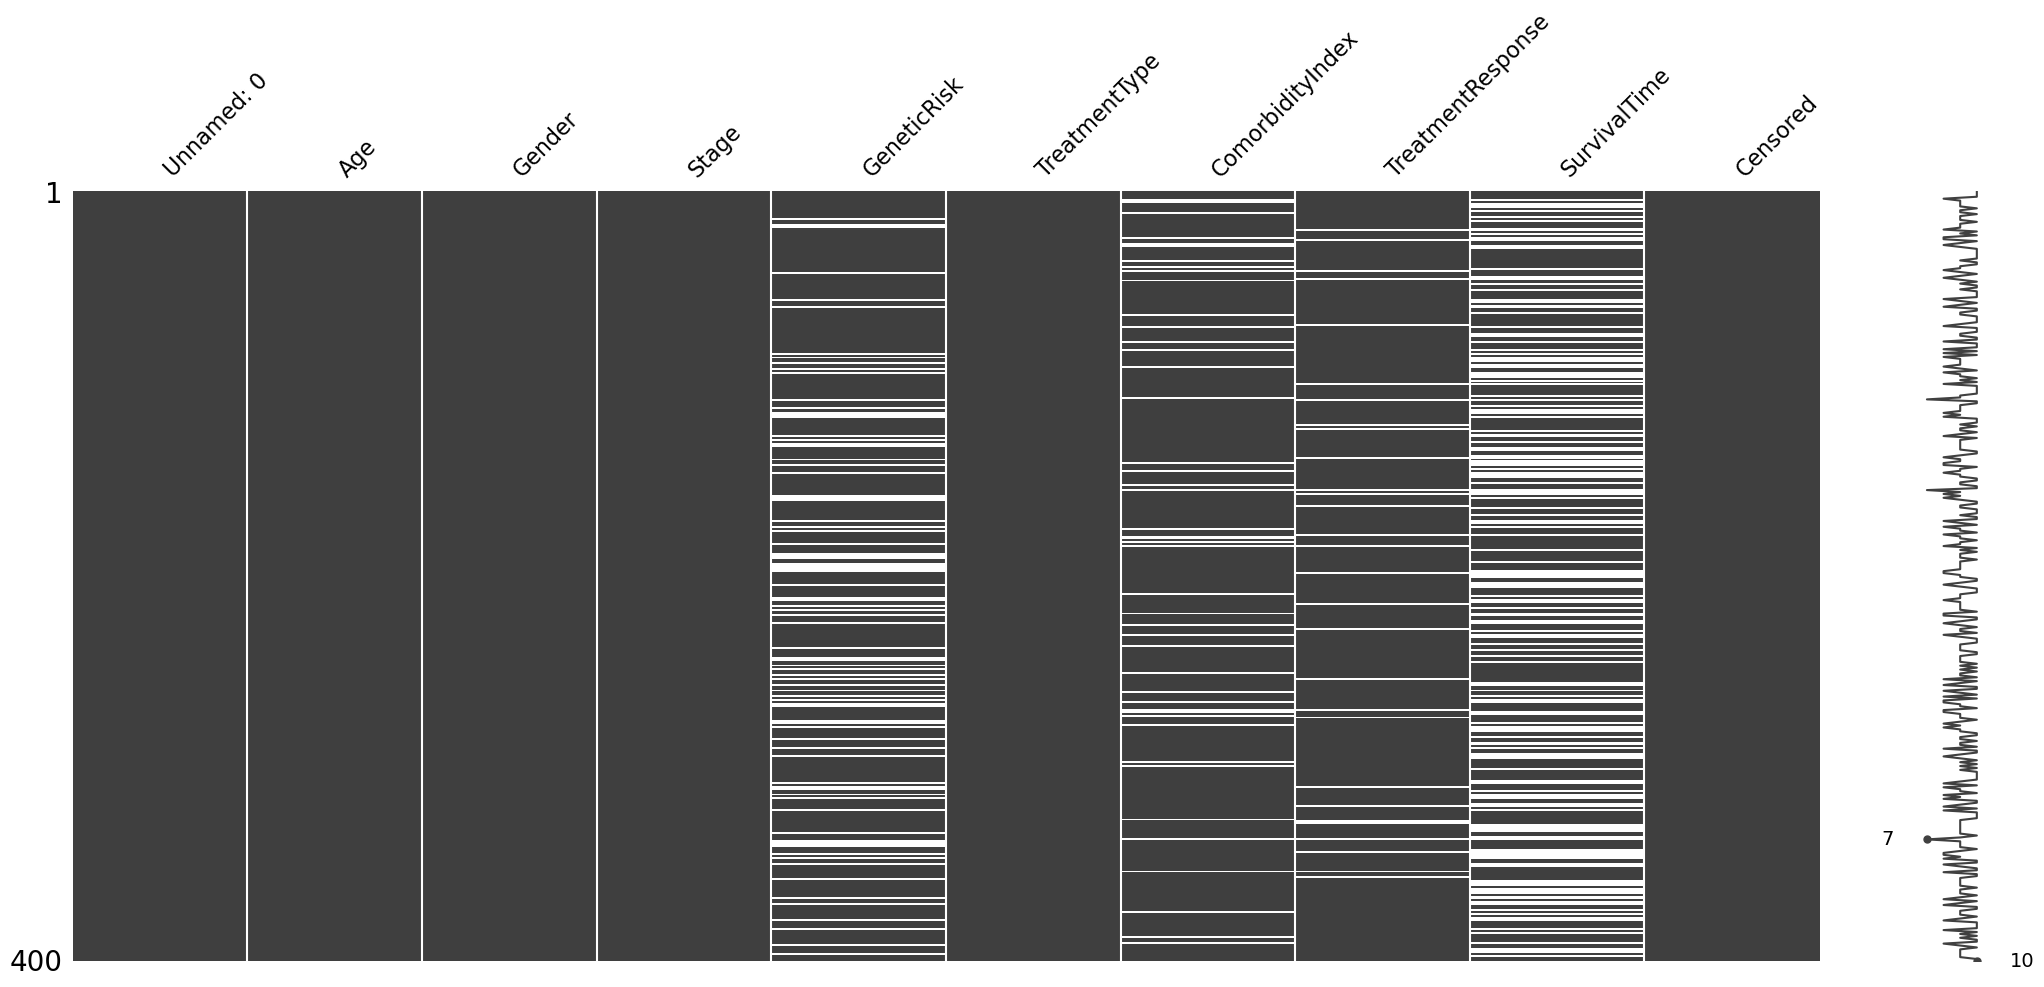

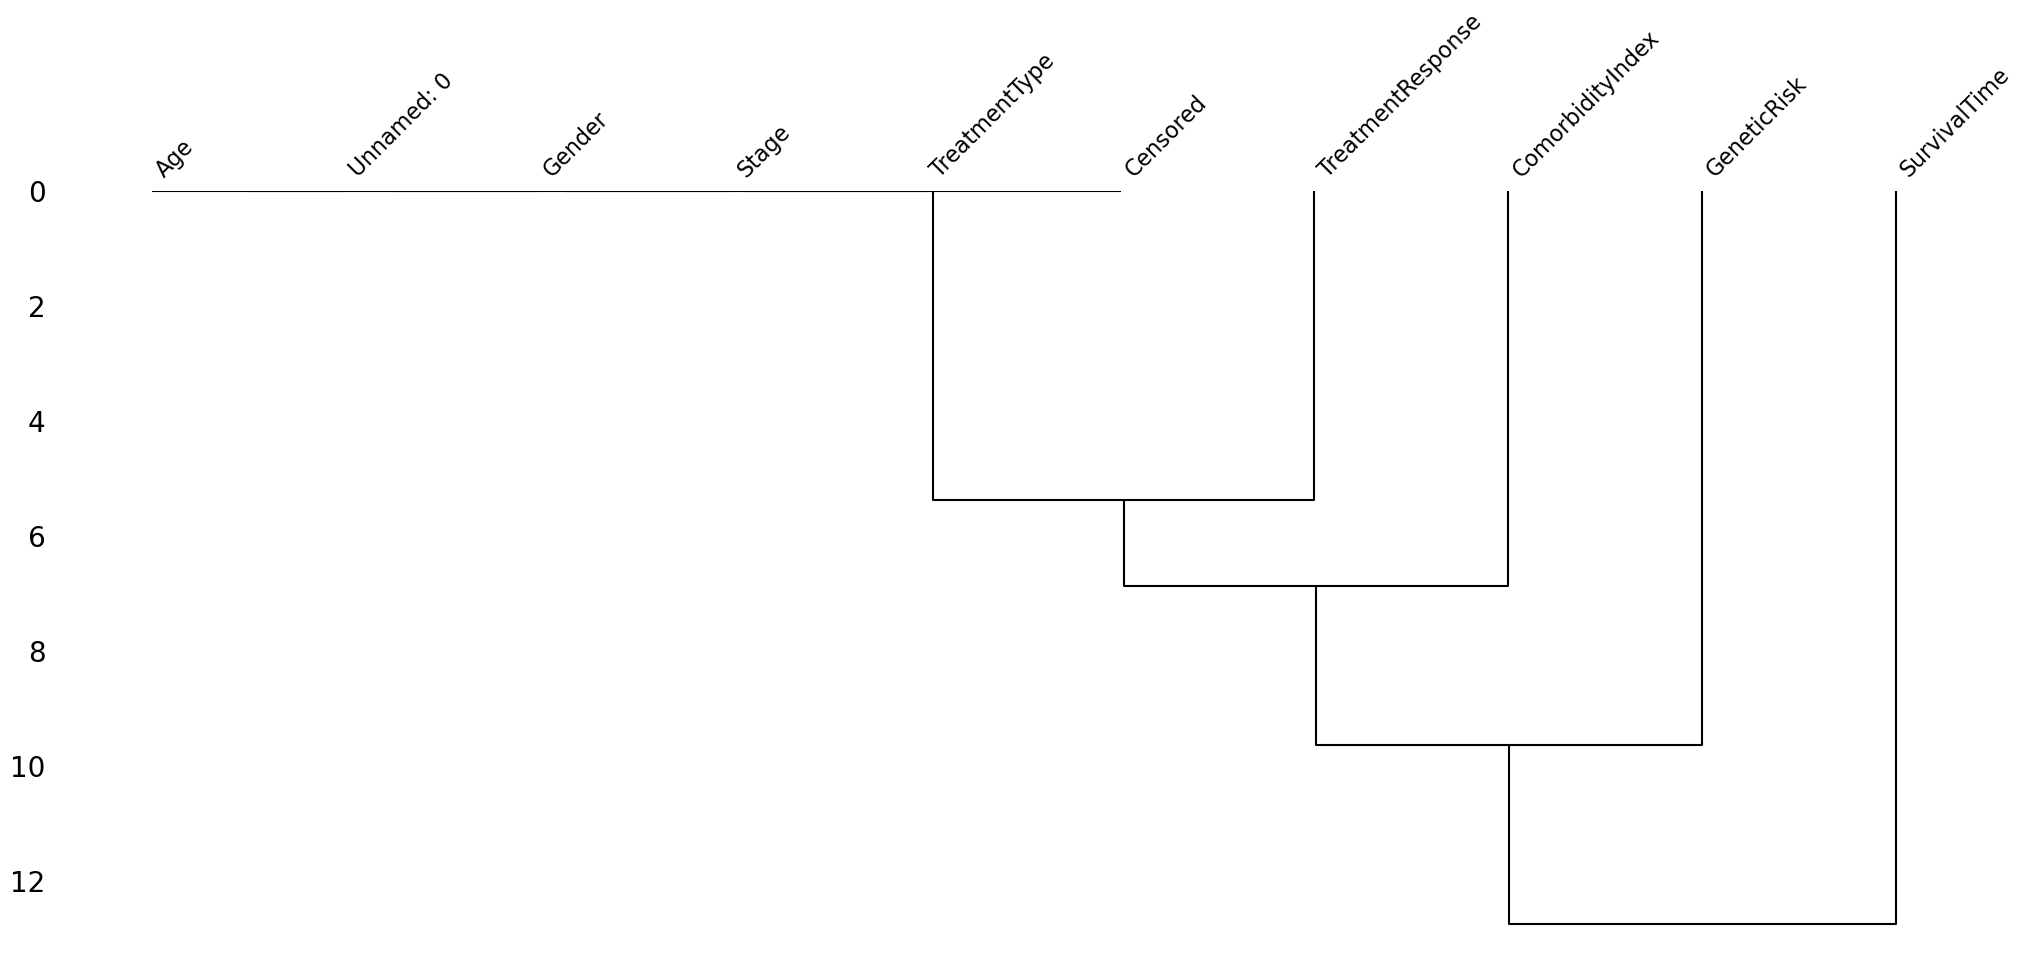

In [3]:
train = pd.read_csv("../data/train_data.csv")
test  = pd.read_csv("../data/test_data.csv")

msno.bar(train)
msno.heatmap(train)
msno.matrix(train)
msno.dendrogram(train)                                        

<h3> Droupout lines: missing values and censored <h3>

In [4]:
#Dataset Analysis before the droupout
print("Initial Analysis of the training set:")
print(f"Total training exemples: {len(train)}")
print(f"\nMissing values per column:")
print(train.isnull().sum())
print(f"Censored exemples: {train['Censored'].sum()} ({100*train['Censored'].sum()/len(train):.1f}%)")
print(f"Non Censored exemples: {(train['Censored']==0).sum()} ({100*(train['Censored']==0).sum()/len(train):.1f}%)")

#Droupout lines with missing values 
#Columns with missing values
cols_to_check = ["TreatmentResponse", "GeneticRisk", "ComorbidityIndex", "SurvivalTime"]

#Remove every line with at least one missing value in the specified columns
train_clean = train.dropna(subset=cols_to_check)
print("Number of lines without missing values:", len(train_clean))

#Dropout lines with censored
#Remove every line with Censored=1
train_final = train_clean[train_clean["Censored"] == 0]

print("Number of lines withou censored values:", len(train_final))

Initial Analysis of the training set:
Total training exemples: 400

Missing values per column:
Unnamed: 0             0
Age                    0
Gender                 0
Stage                  0
GeneticRisk           85
TreatmentType          0
ComorbidityIndex      45
TreatmentResponse     29
SurvivalTime         160
Censored               0
dtype: int64
Censored exemples: 79 (19.8%)
Non Censored exemples: 321 (80.2%)
Number of lines without missing values: 153
Number of lines withou censored values: 109


<h3> Pairplot between target (Survival Time) and Features <h3>

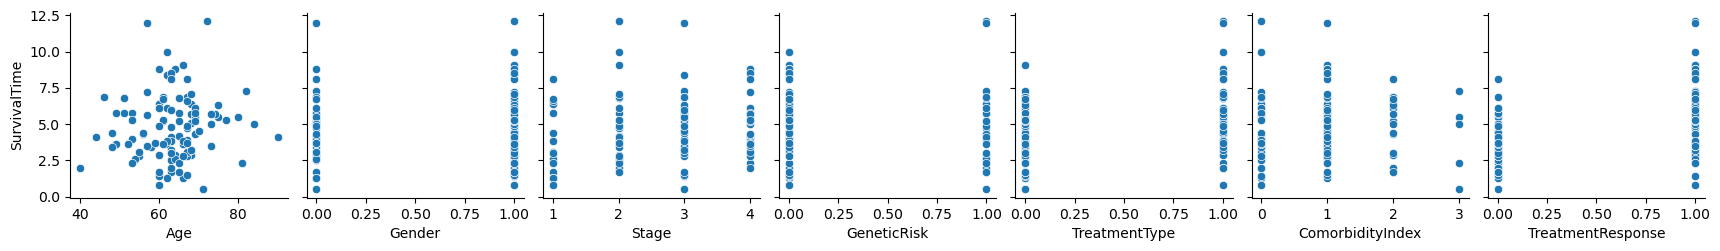

In [5]:
#Define target and features
target = "SurvivalTime"
features = [
    "Age", "Gender", "Stage", "GeneticRisk",
    "TreatmentType", "ComorbidityIndex",
    "TreatmentResponse"]

df = train_final[features + [target]]

# Features we use in models (without missing in train and test)
model_features = ["Age", "Gender", "Stage", "TreatmentType"]

#Creating pairplot
sns.pairplot(df, y_vars=[target], x_vars=features)
plt.show()

<h3> Matrix of X and vector of Y <h3>

In [6]:
#Creating the matrix and the vector 
X = train_final[model_features].values
y = train_final["SurvivalTime"].values  

<h3> Comparing Splitting Strategies <h3>

In [7]:
n_total = len(train_final)

#Train/Val/Test split (60/20/20)
train_size_1 = int(0.6 * n_total)
val_size_1 = int(0.2 * n_total)
test_size_1 = n_total - train_size_1 - val_size_1

print(f"Train/Val/Test (60/20/20):")
print(f"Train: {train_size_1} exemples")
print(f"Val: {val_size_1} exemples")
print(f"Test: {test_size_1} exemples")

#Train/Test + 5-Fold CV
train_size_2 = int(0.8 * n_total)
test_size_2 = n_total - train_size_2

print(f"Train/Test (80/20) + 5-Fold CV:")
print(f"Train: {train_size_2} exemplos")
print(f"Test: {test_size_2} exemplos")
print(f"Each fold in train in CV: ~{int(0.8 * train_size_2)} exemples")
print(f"Each fold in validation in CV: ~{int(0.2 * train_size_2)} exemples")

Train/Val/Test (60/20/20):
Train: 65 exemples
Val: 21 exemples
Test: 23 exemples
Train/Test (80/20) + 5-Fold CV:
Train: 87 exemplos
Test: 22 exemplos
Each fold in train in CV: ~69 exemples
Each fold in validation in CV: ~17 exemples


<h3> Defining new metric cMSE <h3>

In [8]:
def error_metric(y, y_hat, c):
    err = y - y_hat
    err = (1 - c) * err**2 + c * np.maximum(0, err)**2
    return np.sum(err) / err.shape[0]

<h2> Task 1.2 - Learn the baseline model <h2>

Train size: 87
Test size: 22
Cross-validated MSE: 4.481477766670382
Final Test MSE: 5.893445077933217


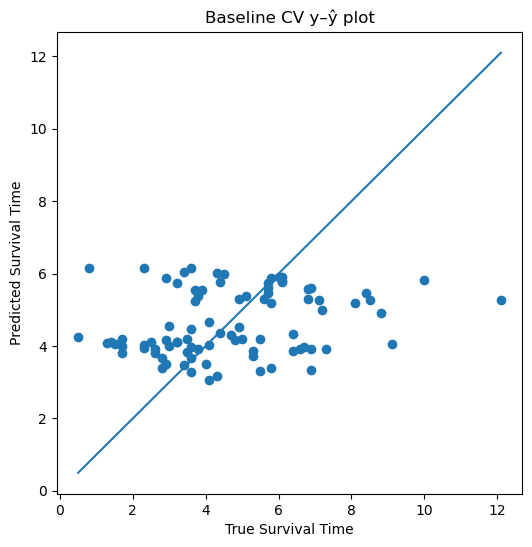

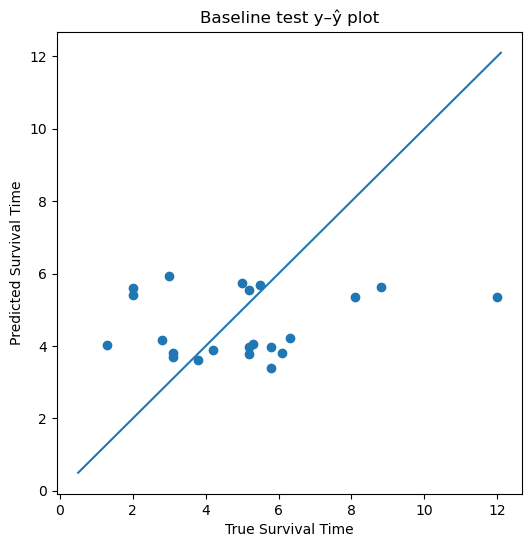

In [9]:
#Splitting the dataset for Cross Validation
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(
    X,
    y,
    train_final["Censored"].values,  # inclui censura aqui
    test_size=0.2,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

#Baseline model with Linear Regression and Standard Scaler
baseline = make_pipeline(StandardScaler(with_mean=True), LinearRegression())

#Cross-validation to evaluate the baseline model
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_hat_cv = cross_val_predict(baseline, X_train, y_train, cv=cv)

mse_cv =mean_squared_error(y_train, y_hat_cv)
print("Cross-validated MSE:", mse_cv)

#Fitting the baseline model
baseline.fit(X_train, y_train)
y_test_hat = baseline.predict(X_test)

#Using MSE as error metric beacause for data with c=0 MSE=cMSE
mse_test = mean_squared_error(y_test, y_test_hat)
print("Final Test MSE:", mse_test)

#Y_y_hat plot
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_hat_cv)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time")
plt.title("Baseline CV y–ŷ plot")
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_hat)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time")
plt.title("Baseline test y–ŷ plot")
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.show()

In [10]:
# === Kaggle submission para o baseline ===

# (Re)treinar o baseline em TODO o train_final com as mesmas features dos modelos
baseline = make_pipeline(StandardScaler(with_mean=True), LinearRegression())
baseline.fit(train_final[model_features].values, train_final["SurvivalTime"].values)

# Verificar se o test não tem NaN nestas colunas
print(test[model_features].isnull().sum())

# Previsão no conjunto de teste
test_pred = baseline.predict(test[model_features])

# Criar submission no formato do sample_submission.csv (id, 0)
sub = pd.DataFrame({
    "id": test["id"],
    "0": test_pred
})

sub.to_csv("baseline-submission-01.csv", index=False)
print("Submission saved as baseline-submission-01.csv")


Age              0
Gender           0
Stage            0
TreatmentType    0
dtype: int64
Submission saved as baseline-submission-01.csv


c:\Users\DESKTOP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


<h1> Task 2 - Nonlinear models <h2>

<h2> Tssk 2.1 - Development <h2>

<h3> Polynomial Model <h3>

In [11]:
#Define the regressor by Ridge regularization to use in the pipeline
def pick_regressor(use_ridge=False, ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0)): #Defining the value of lambda for Ridge regularization(penalty term)
    if use_ridge:
        alphas_array = np.array(ridge_alphas)  # If ridge is used, convert the alphas to a numpy array
        regressor = RidgeCV(alphas=alphas_array)  # The model is a linear regression with Ridge
    else:
        regressor = LinearRegression()  # If ridge is not used, the model is a simple linear regression
    return regressor

#Creates a validation function for polynomial regression models to choose the best degree and model
def train_polynomial_cv(
    X_train, y_train,  #Split data from the make_train_val_test_split function
    degrees=range(1, 8),
    cv=5, 
    random_state=42,
    use_ridge=False,
    ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0)):
    
    #Cross-validation setup
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    results = {
        'degrees': [],
        'n_features': [],
        'mse_train': [],
        'mse_cv': []}
    
    #Training for each degree
    for degree in degrees:
        #Create pipeline with StandardScaler, PolynomialFeatures, and chosen regressor
        regr = pick_regressor(use_ridge=use_ridge, ridge_alphas=ridge_alphas)
        model = make_pipeline(
            StandardScaler(with_mean=True),
            PolynomialFeatures(degree=degree, include_bias=False),
            regr)
        
        #Cross-validation predictions
        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv_splitter)
        mse_cv = mean_squared_error(y_train, y_pred_cv)
        
        cv_results = cross_validate(
            model, X_train, y_train,
            cv=cv_splitter,
            scoring='neg_mean_squared_error',
            return_train_score=True,
            n_jobs=-1)
        
        mse_train = -cv_results['train_score'].mean()
        mse_cv = -cv_results['test_score'].mean()

        #Train on full training set to get training error
        model.fit(X_train, y_train)
        n_features = model.named_steps['polynomialfeatures'].n_output_features_
        
        #Store results
        results['degrees'].append(degree)
        results['n_features'].append(n_features)
        results['mse_train'].append(mse_train)
        results['mse_cv'].append(mse_cv)
        
        print(f"Degree {degree}:"
              f"Number features = {n_features}, "
              f"Train MSE = {mse_train:.2f}, "
              f"CV MSE = {mse_cv:.2f}")
    
    #Select best degree (lowest CV MSE)
    best_idx = np.argmin(results['mse_cv'])
    best_degree = results['degrees'][best_idx]
    best_cv_mse = results['mse_cv'][best_idx]
    
    print(f"BEST POLYNOMIAL DEGREE: {best_degree} (CV MSE = {best_cv_mse:.2f})")

    # Train final model with best degree - FIXED
    regr_final = pick_regressor(use_ridge=use_ridge, ridge_alphas=ridge_alphas)
    best_model = make_pipeline(
        StandardScaler(with_mean=True),
        PolynomialFeatures(degree=best_degree, include_bias=False),
        regr_final)

    best_model.fit(X_train, y_train)
    
    return best_model, results

def plot_polynomial_results(results_linear, results_ridge, save_path=None):

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. MSE vs Degree
    ax = axes[0, 0]
    ax.plot(results_linear['degrees'], results_linear['mse_train'], 
            'o-', label='Train (No Ridge)', color='blue', alpha=0.7)
    ax.plot(results_linear['degrees'], results_linear['mse_cv'], 
            's-', label='CV (No Ridge)', color='blue')
    ax.plot(results_ridge['degrees'], results_ridge['mse_train'], 
            'o-', label='Train (Ridge)', color='red', alpha=0.7)
    ax.plot(results_ridge['degrees'], results_ridge['mse_cv'], 
            's-', label='CV (Ridge)', color='red')
    ax.set_xlabel('Polynomial Degree')
    ax.set_ylabel('MSE')
    ax.set_title('MSE vs Polynomial Degree')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Feature Complexity
    ax = axes[0, 1]
    ax.plot(results_linear['degrees'], results_linear['n_features'], 
            'o-', label='Number of Features', color='green', linewidth=2)
    ax.set_xlabel('Polynomial Degree')
    ax.set_ylabel('Number of Features')
    ax.set_title('Model Complexity (Feature Count)')
    ax.legend()
    ax.grid(True, alpha=0.3)


Polynomial Regression Without Ridge Regularization
Degree 1:Number features = 4, Train MSE = 3.84, CV MSE = 4.49
Degree 2:Number features = 14, Train MSE = 3.36, CV MSE = 6.29
Degree 3:Number features = 34, Train MSE = 2.43, CV MSE = 26.71
Degree 4:Number features = 69, Train MSE = 1.43, CV MSE = 232.44
Degree 5:Number features = 125, Train MSE = 0.99, CV MSE = 107949.40
BEST POLYNOMIAL DEGREE: 1 (CV MSE = 4.49)
Polynomial Regression With Ridge Regularization
Degree 1:Number features = 4, Train MSE = 3.88, CV MSE = 4.57
Degree 2:Number features = 14, Train MSE = 3.92, CV MSE = 4.75
Degree 3:Number features = 34, Train MSE = 4.00, CV MSE = 5.11
Degree 4:Number features = 69, Train MSE = 3.93, CV MSE = 5.14
Degree 5:Number features = 125, Train MSE = 3.52, CV MSE = 6.63
BEST POLYNOMIAL DEGREE: 1 (CV MSE = 4.57)


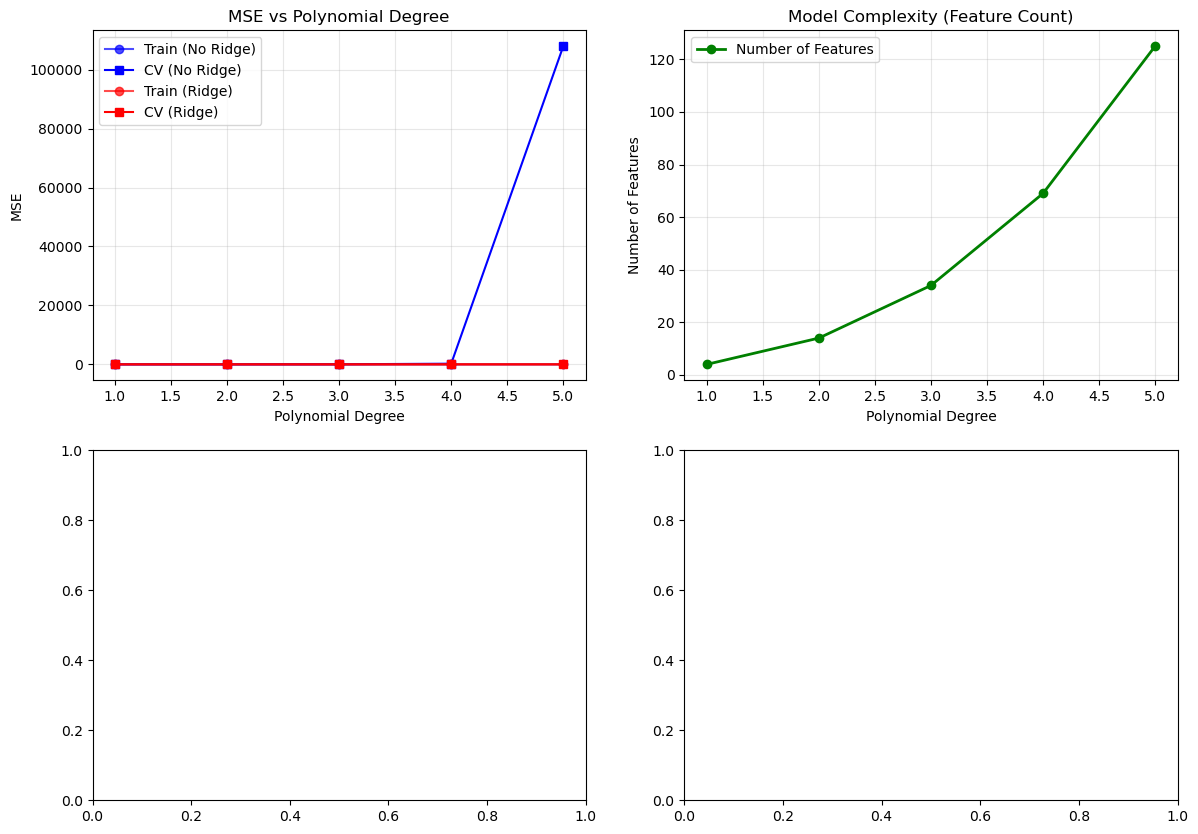

In [12]:
#Polynomial Regression without Ridge regularization
print("Polynomial Regression Without Ridge Regularization")

poly_model_linear, poly_results_linear = train_polynomial_cv(
    X_train, y_train, 
    degrees=range(1, 6),  
    cv=5,
    use_ridge=False, 
    random_state=42)

#Polynomial Regression without Ridge regularization
print("Polynomial Regression With Ridge Regularization")

poly_model_ridge, poly_results_ridge = train_polynomial_cv(
    X_train, y_train, 
    degrees=range(1, 6),  
    cv=5,
    use_ridge=True, 
    ridge_alphas=(0.1, 1.0, 10.0, 100.0, 1000.0),  
    random_state=42)

plot_polynomial_results(poly_results_linear, poly_results_ridge)


<h3> KNN Model <h3>

In [13]:
#k-Nearest Neighbors regression with Cross-Validation to choose the best k
def train_knn_cv(X_train, y_train, k_values=range(1, 30), cv=5, random_state=42):
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    results = {'k_values': [], 'mse_train': [], 'mse_cv': [], 'std_cv': []}
    
    print("k-Nearest Neighbors:")
    
    #Training for each k
    for k in k_values:
        model = make_pipeline(
            StandardScaler(with_mean=True),
            KNeighborsRegressor(n_neighbors=k))
        
        #Cross-validation predictions
        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv_splitter)
        mse_cv = mean_squared_error(y_train, y_pred_cv)
        
        cv_results = cross_validate(
            model, X_train, y_train,
            cv=cv_splitter,
            scoring='neg_mean_squared_error',
            return_train_score=True,
            n_jobs=-1)
        
        mse_train = -cv_results['train_score'].mean()
        mse_cv = -cv_results['test_score'].mean()
        
        model.fit(X_train, y_train)
        
        results['k_values'].append(k)
        results['mse_train'].append(mse_train)
        results['mse_cv'].append(mse_cv)
        
        if k <= 10 or k % 5 == 0:
            print(f"k={k:2d}: Train MSE={mse_train:.2f}, CV MSE={mse_cv:.2f}")
    
    best_idx = np.argmin(results['mse_cv'])
    best_k = results['k_values'][best_idx]
    print(f"\nBEST k: {best_k} (CV MSE = {results['mse_cv'][best_idx]:.2f})")
    
    best_model = make_pipeline(
        StandardScaler(with_mean=True),
        KNeighborsRegressor(n_neighbors=best_k)
    )
    best_model.fit(X_train, y_train)
    
    return best_model, results

In [14]:
knn_model, knn_results = train_knn_cv(
        X_train, y_train,
        k_values=range(1, 30), 
        cv=5,
        random_state=42)

k-Nearest Neighbors:
k= 1: Train MSE=0.33, CV MSE=8.70
k= 2: Train MSE=2.06, CV MSE=6.83
k= 3: Train MSE=2.58, CV MSE=5.58
k= 4: Train MSE=2.91, CV MSE=5.05
k= 5: Train MSE=3.11, CV MSE=4.76
k= 6: Train MSE=3.18, CV MSE=4.84
k= 7: Train MSE=3.27, CV MSE=4.56
k= 8: Train MSE=3.35, CV MSE=4.49
k= 9: Train MSE=3.51, CV MSE=4.31
k=10: Train MSE=3.58, CV MSE=4.39
k=15: Train MSE=3.75, CV MSE=4.31
k=20: Train MSE=3.88, CV MSE=4.31
k=25: Train MSE=3.97, CV MSE=4.37

BEST k: 18 (CV MSE = 4.24)


<h2> Task 2.2 - Evaluation <h2>

In [15]:
#Comprehensive evaluation function
def evaluate_model_comprehensive(model, X_train, y_train, X_test, y_test, 
                                 model_name, cv=5, random_state=42):

    #Cross-validation predictions on training set
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv_splitter)
    
    #Train set predictions (refit on full training set)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    
    #Test set predictions
    y_test_pred = model.predict(X_test)
    
    #Calculate errors
    train_errors = y_train - y_train_pred
    cv_errors = y_train - y_train_pred_cv
    test_errors = y_test - y_test_pred
    
    #Compile results
    results = {
        'Model': model_name,
        
        # Training and Cross-Validation Metrics
        'Train_MSE': mean_squared_error(y_train, y_train_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'CV_MSE': mean_squared_error(y_train, y_train_pred_cv),
        'CV_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_cv)),
        
        # Test Set Metrics
        'Test_MSE': mean_squared_error(y_test, y_test_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))}
        
    return results

#Function to compare multiple models
def compare_models(models_dict, X_train, y_train, X_test, y_test, cv=5, random_state=42):
    
    all_results = []

    for model_name, model in models_dict.items():
        results = evaluate_model_comprehensive(
            model, X_train, y_train, X_test, y_test, 
            model_name, cv, random_state)
        all_results.append(results)
    
    #Create comprehensive DataFrame
    results_df = pd.DataFrame([{k: v for k, v in r.items() 
                                if k not in ['y_test_pred', 'test_errors']} 
                               for r in all_results])
    
    return results_df, all_results

def print_comparison_tables(results_df):

    #Main metrics table
    main_metrics = results_df[['Model', 'Train_MSE', 'CV_MSE', 'Test_MSE', 
                                'Train_RMSE', 'CV_RMSE', 'Test_RMSE']].copy()
    print(main_metrics.to_string(index=False))
    
    print("Ranking of Models Based on Test MSE:")
    #Ranking
    ranking = results_df[['Model', 'Test_MSE', 'Test_RMSE', 'CV_MSE']].copy()
    ranking = ranking.sort_values('Test_MSE')
    ranking['Rank'] = range(1, len(ranking) + 1)
    ranking = ranking[['Rank', 'Model', 'Test_MSE', 'Test_RMSE', 'CV_MSE']]
    print(ranking.to_string(index=False))
    
    #Print best model
    best_model = ranking.iloc[0]
    print(f"Best Model: {best_model['Model']}")
    print(f"Test MSE: {best_model['Test_MSE']:.4f}")
    print(f"Test RMSE: {best_model['Test_RMSE']:.4f}")    
    return ranking

#Function to plot model comparison with MSE values
def plot_model_comparison(results_df, all_results, y_test):
    
    n_models = len(results_df)
    x_pos = np.arange(n_models)
    width = 0.25
    plt.figure(figsize=(12, 6))
    plt.bar(x_pos - width, results_df['Train_MSE'], width, label='Train MSE', alpha=0.8)
    plt.bar(x_pos, results_df['CV_MSE'], width, label='CV MSE', alpha=0.8)
    plt.bar(x_pos + width, results_df['Test_MSE'], width, label='Test MSE', alpha=0.8)
    plt.xlabel('Model')
    plt.ylabel('MSE')
    plt.title('MSE Comparison Across Models')
    plt.xticks(x_pos, results_df['Model'], rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

                       Model  Train_MSE   CV_MSE  Test_MSE  Train_RMSE  CV_RMSE  Test_RMSE
Baseline (Linear Regression)   3.898565 4.481478  5.893445    1.974478 2.116950   2.427642
 Polynomial Ridge (Degree 1)   3.907282 4.545916  5.783719    1.976685 2.132115   2.404936
                 k-NN (k=18)   3.869564 4.227796  5.814891    1.967121 2.056160   2.411408
Ranking of Models Based on Test MSE:
 Rank                        Model  Test_MSE  Test_RMSE   CV_MSE
    1  Polynomial Ridge (Degree 1)  5.783719   2.404936 4.545916
    2                  k-NN (k=18)  5.814891   2.411408 4.227796
    3 Baseline (Linear Regression)  5.893445   2.427642 4.481478
Best Model: Polynomial Ridge (Degree 1)
Test MSE: 5.7837
Test RMSE: 2.4049


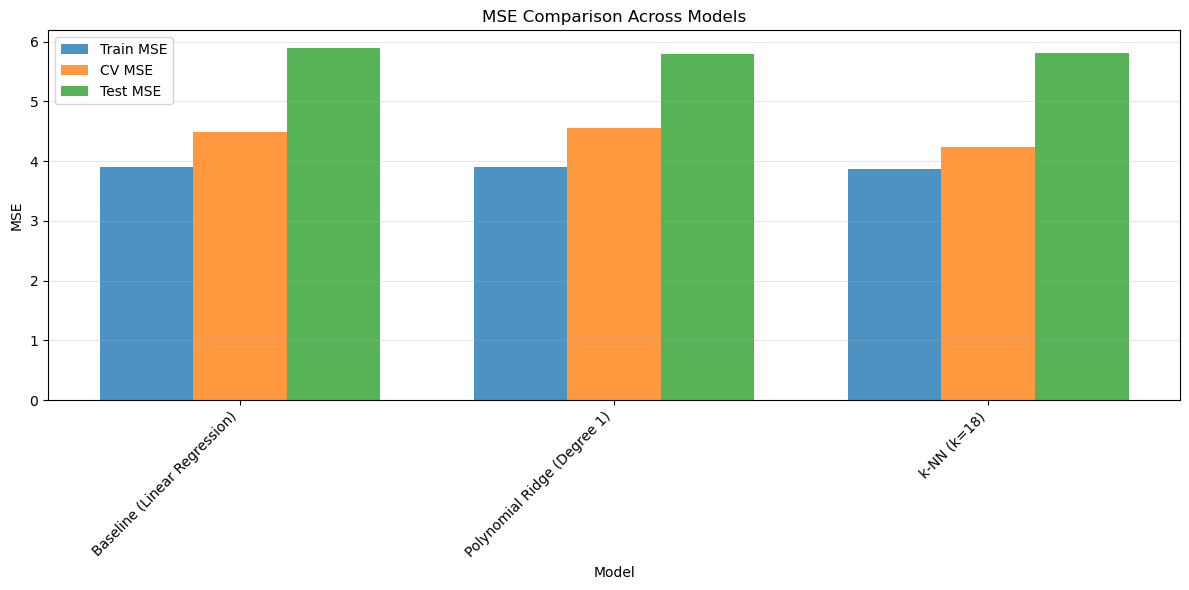

In [16]:
best_degree_ridge = poly_results_ridge['degrees'][np.argmin(poly_results_ridge['mse_cv'])]
best_k = knn_results['k_values'][np.argmin(knn_results['mse_cv'])]

models_dict = {
    "Baseline (Linear Regression)": baseline,
    f"Polynomial Ridge (Degree {best_degree_ridge})": poly_model_ridge,
    f"k-NN (k={best_k})": knn_model,
}

#Comprehensive comparison
results_df, all_results = compare_models(
    models_dict, X_train, y_train, X_test, y_test, 
    cv=5, random_state=42)
    
#rint comparison tables
ranking = print_comparison_tables(results_df)
    
#Create plot
plot_model_comparison (results_df, all_results, y_test)

In [17]:
import os


# 1) Select the best model according to Test_MSE from the comparison table
#    (lower Test_MSE is better)
best_row = results_df.sort_values("Test_MSE").iloc[0]
best_model_name = best_row["Model"]
print(f"\nBest model for Task 2: {best_model_name}")

# 2) Retrieve the corresponding model object from models_dict
best_model = models_dict[best_model_name]

# 3) Train the best model on the full training data using the same model_features
X_full = train_final[model_features].values
y_full = train_final["SurvivalTime"].values

best_model.fit(X_full, y_full)

# 4) Prepare the test features (must use the same model_features)
X_test_full = test[model_features].values

# 5) Predict survival time for the test set
test_pred_nonlinear = best_model.predict(X_test_full)

# 6) Ensure the output directory exists (relative to the notebook path)
os.makedirs("../outputs/csv", exist_ok=True)

# 7) Build the submission DataFrame in Kaggle format (columns: id, 0)
sub_nonlinear = pd.DataFrame({
    "id": test["id"],   # id column from test_data.csv
    "0": test_pred_nonlinear  # predicted SurvivalTime
})

# 8) Save the submission file for Task 2
output_path = "../outputs/csv/Nonlinear-submission-01.csv"
sub_nonlinear.to_csv(output_path, index=False)

print(f"Nonlinear submission saved to {output_path}")



Best model for Task 2: Polynomial Ridge (Degree 1)
Nonlinear submission saved to ../outputs/csv/Nonlinear-submission-01.csv


<h1> Task 3 - Handling missing data </h1>
<h2> Task 3.1 - Missing data imputation </h2>

Train size used in Task 3.1 (with missing features allowed): 161
Missing values per feature (Task 3.1 dataset):
Age                   0
Gender                0
Stage                 0
GeneticRisk          27
TreatmentType         0
ComorbidityIndex     18
TreatmentResponse    11
dtype: int64
Task 3.1 - Train size: 128
Task 3.1 - Test size: 33

=== Evaluating imputation strategy: mean ===

=== Evaluating imputation strategy: median ===

=== Evaluating imputation strategy: most_frequent ===

=== Evaluating imputation strategy: constant_zero ===

=== Evaluating imputation strategy: knn_5 ===

=== Task 3.1 - Baseline with different imputation strategies ===
     Strategy   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE  Test_Error_Mean  Test_Error_Std  Test_Error_Min  Test_Error_Max
         mean 3.724064 1.929783  3.385637   1.840010        -0.378024        1.800759       -3.330081        4.089464
        knn_5 3.687735 1.920348  3.403570   1.844877        -0.381239        1.805056       -3.305248 

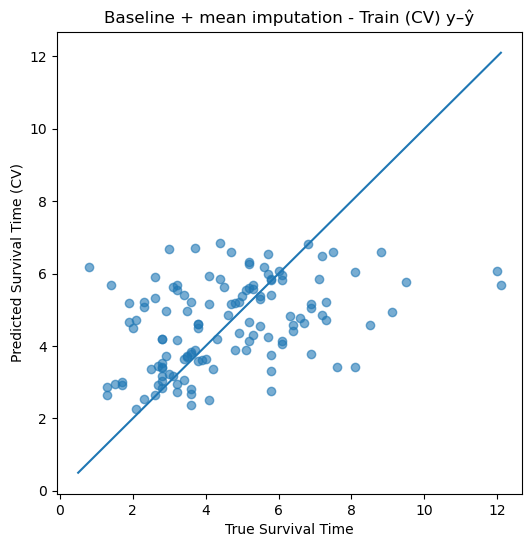

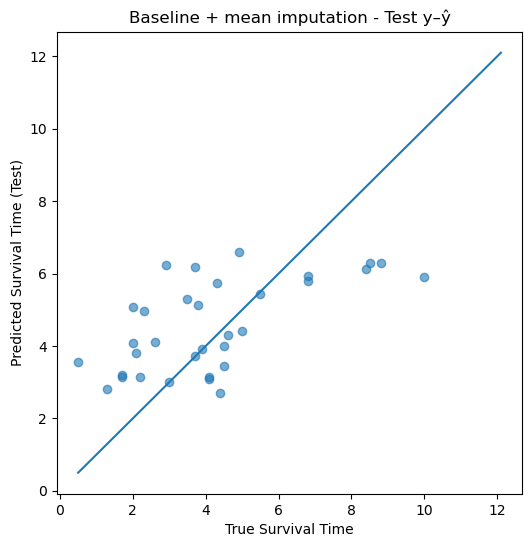

In [18]:
from sklearn.impute import SimpleImputer, KNNImputer

# ============================================================
# 1. Build supervised dataset including rows with missing features
# ============================================================

# We now include rows that may have missing feature values.
# We still restrict to uncensored patients (Censored == 0) and
# require SurvivalTime to be observed (no missing target).

full_feature_cols = [
    "Age", "Gender", "Stage", "GeneticRisk",
    "TreatmentType", "ComorbidityIndex",
    "TreatmentResponse",
]

supervised_mask = (train["Censored"] == 0) & train["SurvivalTime"].notna()
train_imp = train.loc[supervised_mask].copy()

print("Train size used in Task 3.1 (with missing features allowed):", len(train_imp))
print("Missing values per feature (Task 3.1 dataset):")
print(train_imp[full_feature_cols].isnull().sum())

X_imp = train_imp[full_feature_cols].values
y_imp = train_imp["SurvivalTime"].values

# Train/test split for evaluation (similar to Task 1.2 but now with missing features)
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imp,
    y_imp,
    test_size=0.2,
    random_state=42
)

print("Task 3.1 - Train size:", len(X_train_imp))
print("Task 3.1 - Test size:", len(X_test_imp))

# ============================================================
# 2. Imputation strategies + baseline model (Linear Regression)
# ============================================================

# Define different imputation strategies to try with the baseline model
imputation_strategies = {
    "mean": SimpleImputer(strategy="mean"),
    "median": SimpleImputer(strategy="median"),
    "most_frequent": SimpleImputer(strategy="most_frequent"),
    "constant_zero": SimpleImputer(strategy="constant", fill_value=0.0),
    "knn_5": KNNImputer(n_neighbors=5, weights="uniform"),
}

def evaluate_baseline_with_imputer(imputer_name, imputer, 
                                   X_train, y_train, X_test, y_test,
                                   cv_splits=5, random_state=42):
    """
    Build a pipeline: Imputer -> StandardScaler -> LinearRegression,
    evaluate it with cross-validation on the training data and 
    compute test performance.
    Returns a dictionary with metrics and the fitted model.
    """
    # Build pipeline
    model = make_pipeline(
        imputer,
        StandardScaler(with_mean=True),
        LinearRegression()
    )
    
    # Cross-validation on training data
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)
    cv_mse = mean_squared_error(y_train, y_train_pred_cv)
    cv_rmse = np.sqrt(cv_mse)
    
    # Fit on training set and evaluate on test set
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    
    # Error statistics (for slides)
    test_errors = y_test - y_test_pred
    stats = {
        "Strategy": imputer_name,
        "CV_MSE": cv_mse,
        "CV_RMSE": cv_rmse,
        "Test_MSE": test_mse,
        "Test_RMSE": test_rmse,
        "Test_Error_Mean": np.mean(test_errors),
        "Test_Error_Std": np.std(test_errors),
        "Test_Error_Min": np.min(test_errors),
        "Test_Error_Max": np.max(test_errors),
        "model": model,  # keep fitted model in case this is the best
        "y_test_pred": y_test_pred,
        "y_train_pred_cv": y_train_pred_cv,
    }
    return stats

# Run all strategies and collect results
imputation_results = []
for name, imp in imputation_strategies.items():
    print(f"\n=== Evaluating imputation strategy: {name} ===")
    stats = evaluate_baseline_with_imputer(
        name, imp,
        X_train_imp, y_train_imp,
        X_test_imp, y_test_imp,
        cv_splits=5,
        random_state=42
    )
    imputation_results.append(stats)

# Build a DataFrame with the results (for tables in slides)
imp_results_df = pd.DataFrame([
    {k: v for k, v in d.items() if k not in ["model", "y_test_pred", "y_train_pred_cv"]}
    for d in imputation_results
])

print("\n=== Task 3.1 - Baseline with different imputation strategies ===")
print(imp_results_df.sort_values("Test_MSE").to_string(index=False))

# ============================================================
# 3. Pick the best imputation strategy (based on CV or Test MSE)
# ============================================================

# Here we choose based on Test_MSE (you can justify in slides)
best_row_imp = imp_results_df.sort_values("Test_MSE").iloc[0]
best_strategy_name = best_row_imp["Strategy"]
print(f"\nBest imputation strategy for baseline: {best_strategy_name}")

# Retrieve the corresponding full stats (including model and predictions)
best_stats_full = next(d for d in imputation_results if d["Strategy"] == best_strategy_name)
baseline_imputed_best = best_stats_full["model"]
y_train_cv_best = best_stats_full["y_train_pred_cv"]
y_test_pred_best = best_stats_full["y_test_pred"]

# ============================================================
# 4. y–ŷ plots for the best imputation strategy (baseline)
# ============================================================

plt.figure(figsize=(6, 6))
plt.scatter(y_train_imp, y_train_cv_best, alpha=0.6)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (CV)")
plt.title(f"Baseline + {best_strategy_name} imputation - Train (CV) y–ŷ")
min_y, max_y = y_imp.min(), y_imp.max()
plt.plot([min_y, max_y], [min_y, max_y])
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test_imp, y_test_pred_best, alpha=0.6)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Test)")
plt.title(f"Baseline + {best_strategy_name} imputation - Test y–ŷ")
plt.plot([min_y, max_y], [min_y, max_y])
plt.show()

# These plots + imp_results_df table are what you need to compare Task 3.1
# with the original baseline from Task 1.2 in your slides.


# ============================================================
# 5. Apply best imputation strategy to best models from Task 2
# ============================================================

<h3> Task 3.1 - Applying best imputation to nonlinear models </h3>


=== Task 3.1 - Models with best imputation strategy ===
                    Model  Train_MSE  Train_RMSE   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE
          Baseline + mean   3.035999    1.742412 3.724064 1.929783  3.385637   1.840010
Poly Ridge (deg=1) + mean   3.043543    1.744575 3.646274 1.909522  3.420821   1.849546
       k-NN (k=18) + mean   3.206947    1.790795 3.596984 1.896572  3.699446   1.923394


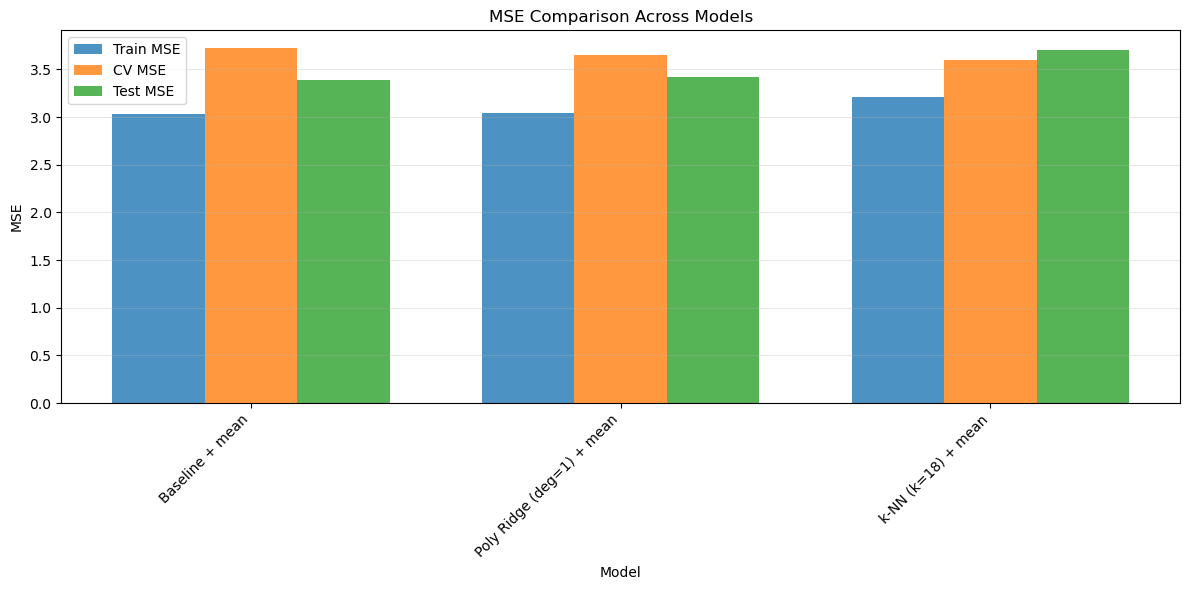

In [19]:
from sklearn.impute import SimpleImputer, KNNImputer

# Rebuild an unfitted imputer corresponding to best_strategy_name
# (so we do not reuse the already-fitted one from before)
if best_strategy_name == "mean":
    best_imputer = SimpleImputer(strategy="mean")
elif best_strategy_name == "median":
    best_imputer = SimpleImputer(strategy="median")
elif best_strategy_name == "most_frequent":
    best_imputer = SimpleImputer(strategy="most_frequent")
elif best_strategy_name == "constant_zero":
    best_imputer = SimpleImputer(strategy="constant", fill_value=0.0)
elif best_strategy_name == "knn_5":
    best_imputer = KNNImputer(n_neighbors=5, weights="uniform")
else:
    raise ValueError(f"Unknown best strategy: {best_strategy_name}")

# We reuse the best hyperparameters found in Task 2:
#   - best_degree_ridge (for Polynomial Ridge)
#   - best_k (for k-NN)
# They should already be defined from Task 2.

# Polynomial Ridge with imputation
poly_ridge_imputed = make_pipeline(
    best_imputer,
    StandardScaler(with_mean=True),
    PolynomialFeatures(degree=best_degree_ridge, include_bias=False),
    RidgeCV(alphas=np.array([0.1, 1.0, 10.0, 100.0, 1000.0]))
)

# k-NN with imputation
knn_imputed = make_pipeline(
    best_imputer,
    StandardScaler(with_mean=True),
    KNeighborsRegressor(n_neighbors=best_k)
)

# Baseline with the best imputer (for comparison in this task)
baseline_imputed = make_pipeline(
    best_imputer,
    StandardScaler(with_mean=True),
    LinearRegression()
)

# Compare the three models on the Task 3.1 dataset (with missing features)
models_task3 = {
    f"Baseline + {best_strategy_name}": baseline_imputed,
    f"Poly Ridge (deg={best_degree_ridge}) + {best_strategy_name}": poly_ridge_imputed,
    f"k-NN (k={best_k}) + {best_strategy_name}": knn_imputed,
}

results_task3_df, _ = compare_models(
    models_task3,
    X_train_imp, y_train_imp,
    X_test_imp, y_test_imp,
    cv=5,
    random_state=42
)

print("\n=== Task 3.1 - Models with best imputation strategy ===")
print(results_task3_df.to_string(index=False))

# Optional: plot comparison of MSE across models in Task 3.1
plot_model_comparison(results_task3_df, _, y_test_imp)

<h2> Task 3.2 - Models that do not require imputation </h2>

In [20]:
import sys
print(sys.executable)

import sys
!{sys.executable} -m pip install catboost


from catboost import CatBoostRegressor, Pool
print("CatBoost import OK")

c:\Users\DESKTOP\anaconda3\python.exe
CatBoost import OK



=== Task 3.2 - Comparison: Baseline (with imputation) vs HistGradientBoosting ===
                                        Model  Train_MSE  Train_RMSE   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE
                      Baseline + mean imputer   3.035999    1.742412 3.724064 1.929783  3.385637   1.840010
HistGradientBoostingRegressor (no imputation)   1.599550    1.264733 4.582118 2.140588  4.045936   2.011451


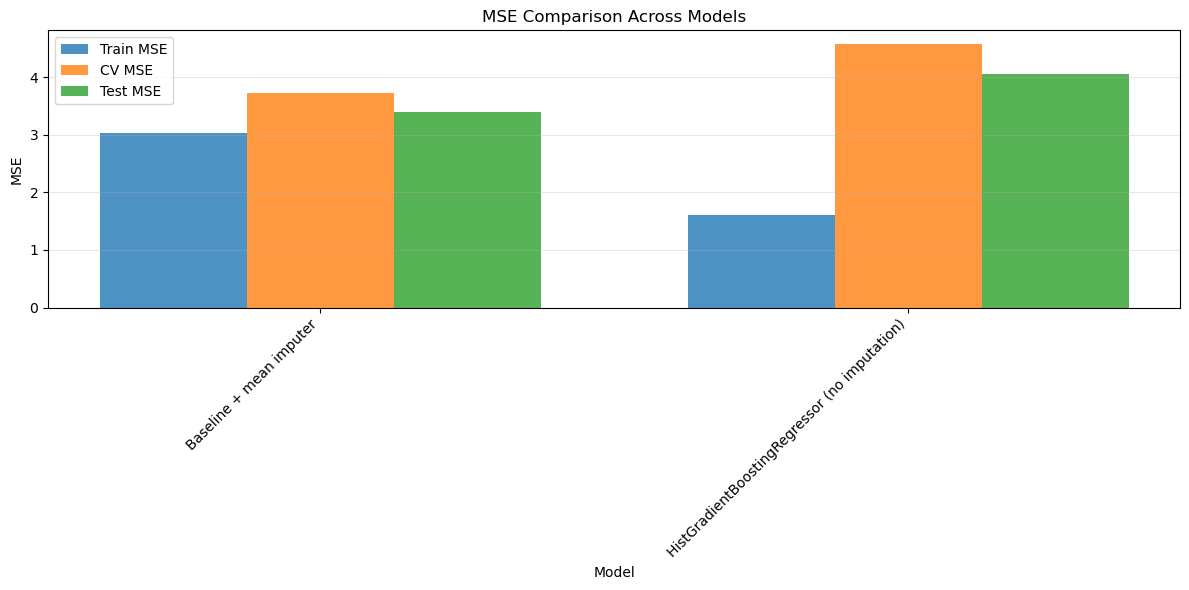

In [21]:

# -------------------------------------------------------------------
# 1. Baseline with best imputation strategy (for comparison)
#    We rebuild the baseline pipeline using the best_imputer found in Task 3.1.
# -------------------------------------------------------------------
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression 

baseline_imputed_t32 = make_pipeline(
    best_imputer,
    StandardScaler(with_mean=True),
    LinearRegression()
)

# -------------------------------------------------------------------
# 2. HistGradientBoostingRegressor
#    This model natively supports missing values (NaN) in the features.
#    We do NOT impute anything here, we pass X with NaN directly.
# -------------------------------------------------------------------

hgb_model = HistGradientBoostingRegressor(
    max_iter=400,
    learning_rate=0.05,
    max_depth=None,
    l2_regularization=0.0,
    random_state=42
)

# We will compare:
#   - Baseline + best imputation (from Task 3.1)
#   - HistGradientBoostingRegressor (no imputation; uses raw X with NaN)
models_task32 = {
    f"Baseline + {best_strategy_name} imputer": baseline_imputed_t32,
    "HistGradientBoostingRegressor (no imputation)": hgb_model,
}

# Note: we evaluate on the Task 3.1 supervised dataset (train_imp),
# which includes missing feature values.
results_task32_df, _ = compare_models(
    models_task32,
    X_train_imp, y_train_imp,
    X_test_imp, y_test_imp,
    cv=5,
    random_state=42
)

print("\n=== Task 3.2 - Comparison: Baseline (with imputation) vs HistGradientBoosting ===")
print(results_task32_df.to_string(index=False))

# Optional: plot MSE comparison for slides
plot_model_comparison(results_task32_df, _, y_test_imp)

# -------------------------------------------------------------------


In [22]:

import catboost
print(catboost.__version__)


1.2.8


In [23]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# 1) Load data (ficheiros já carregados para /content)
train = pd.read_csv("../data/train_data.csv")

full_feature_cols = [
    "Age", "Gender", "Stage", "GeneticRisk",
    "TreatmentType", "ComorbidityIndex", "TreatmentResponse"
]

# 2) Usar todos os pacientes com SurvivalTime conhecido (inclui censurados)
aft_mask = train["SurvivalTime"].notna()
train_aft = train.loc[aft_mask].copy()

X_aft = train_aft[full_feature_cols].values
time_aft = train_aft["SurvivalTime"].values
cens_aft = train_aft["Censored"].values  # 0 = evento, 1 = censura

def make_aft_labels(time, censored):
    """
    Para CatBoost AFT:
      - não censurado (c=0): [T, T]
      - censurado à direita (c=1): [T, +inf]
    """
    lower = time
    upper = np.where(censored == 1, np.inf, time)
    return np.vstack([lower, upper]).T

y_aft = make_aft_labels(time_aft, cens_aft)

# 3) Train/validation split
X_train, X_val, y_train, y_val, cens_train, cens_val = train_test_split(
    X_aft, y_aft, cens_aft, test_size=0.2, random_state=42
)

train_pool = Pool(X_train, y_train)
val_pool   = Pool(X_val, y_val)

# 4) Modelo AFT: atenção ao nome da loss_function
aft_model = CatBoostRegressor(
    loss_function="SurvivalAft:dist=Normal",  # <--- aqui muda!
    eval_metric="SurvivalAft",
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=False
)

aft_model.fit(train_pool, eval_set=val_pool)

# 5) Predições em log-tempo -> exponentiamos
y_pred_log = aft_model.predict(val_pool)
y_pred = np.exp(y_pred_log)

# 6) cMSE
def error_metric(y, y_hat, c):
    err = y - y_hat
    err = (1 - c) * err**2 + c * np.maximum(0, err)**2
    return np.sum(err) / err.shape[0]

time_val = y_val[:, 0]   # limite inferior
cMSE_val = error_metric(time_val, y_pred, cens_val)

print("CatBoost AFT - validation cMSE:", cMSE_val)
print("Number of validation samples:", len(time_val))

Got unsafe target value = inf at object #6 of dataset learn
Got unsafe target value = inf at object #2 of dataset test #0


CatBoost AFT - validation cMSE: 3.0603373045665765
Number of validation samples: 48


<h2> Task 3.3 -  Evaluation </h2>


==================== Task 3.3 - Evaluation ====================

=== Task 3.3 - Global comparison of models (Task 3.1 + 3.2) ===
                                        Model  Train_MSE  Train_RMSE   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE
                              Baseline + mean   3.035999    1.742412 3.724064 1.929783  3.385637   1.840010
                      Baseline + mean imputer   3.035999    1.742412 3.724064 1.929783  3.385637   1.840010
                    Poly Ridge (deg=1) + mean   3.043543    1.744575 3.646274 1.909522  3.420821   1.849546
                           k-NN (k=18) + mean   3.206947    1.790795 3.596984 1.896572  3.699446   1.923394
          HistGradientBoosting + best imputer   1.736459    1.317748 4.493745 2.119846  3.922908   1.980633
HistGradientBoostingRegressor (no imputation)   1.599550    1.264733 4.582118 2.140588  4.045936   2.011451


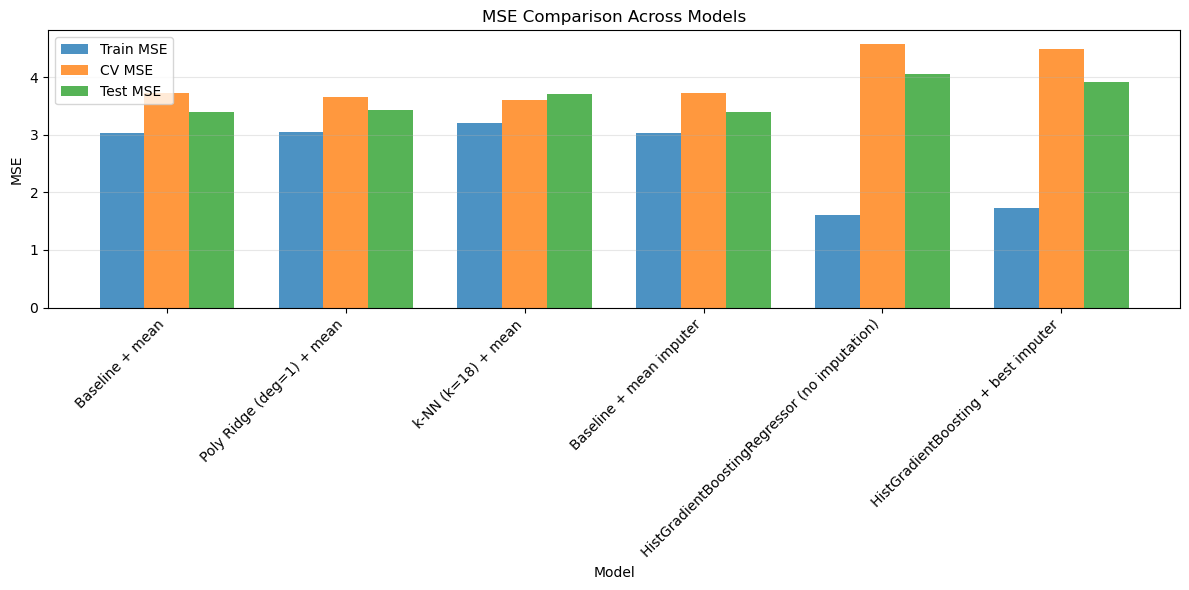


Best overall model in Task 3: Baseline + mean
Test MSE:  3.3856
Test RMSE: 1.8400


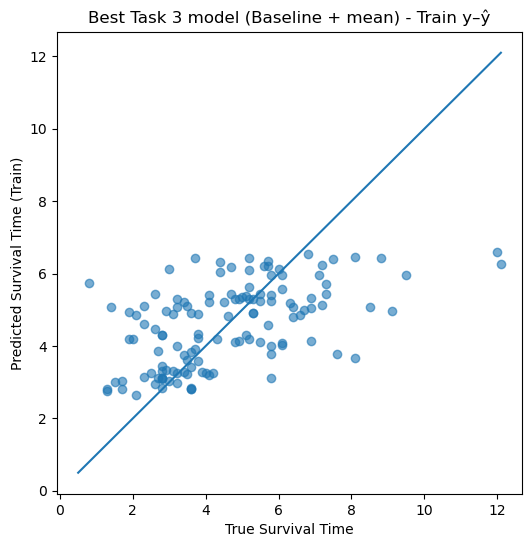

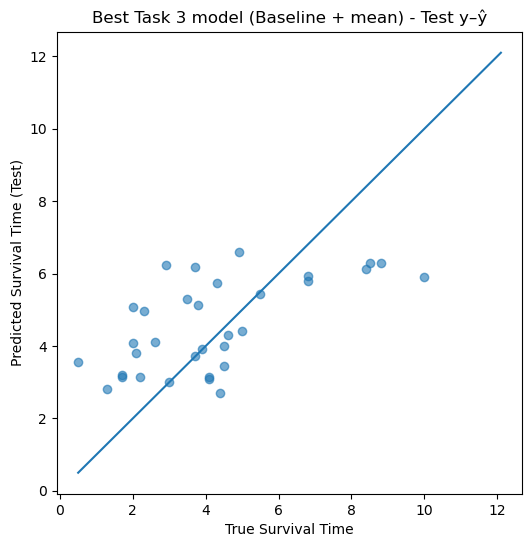


Task 3 submission saved to ../outputs/csv/handle-missing-submission-01.csv
Use this file on Kaggle as: handle-missing-submission-01.csv


In [24]:
# ============================================================
# Task 3.3 - Evaluation and Kaggle submission
# ============================================================

print("\n==================== Task 3.3 - Evaluation ====================")

# ------------------------------------------------------------
# 1. Combine models from Task 3.1 and Task 3.2 in one comparison
# ------------------------------------------------------------

# models_task3   -> baseline + best imputer, poly ridge + imputer, knn + imputer
# models_task32  -> baseline + imputer, HistGradientBoosting (no imputation)

all_models_task3 = {}
all_models_task3.update(models_task3)
all_models_task3.update(models_task32)

# Optional: also try HistGradientBoosting WITH imputation (same best_imputer)
hgb_imputed = make_pipeline(
    best_imputer,
    HistGradientBoostingRegressor(
        max_iter=400,
        learning_rate=0.05,
        max_depth=None,
        l2_regularization=0.0,
        random_state=42
    )
)
all_models_task3["HistGradientBoosting + best imputer"] = hgb_imputed

# Compare all models on the same dataset used in Task 3 (X_train_imp / X_test_imp)
results_task33_df, all_results_task33 = compare_models(
    all_models_task3,
    X_train_imp, y_train_imp,
    X_test_imp, y_test_imp,
    cv=5,
    random_state=42
)

print("\n=== Task 3.3 - Global comparison of models (Task 3.1 + 3.2) ===")
print(results_task33_df.sort_values("Test_MSE").to_string(index=False))

# Plot comparison of Train / CV / Test MSE for all Task 3 models
plot_model_comparison(results_task33_df, all_results_task33, y_test_imp)

# ------------------------------------------------------------
# 2. Pick the overall best model in Task 3
# ------------------------------------------------------------

best_row_task3 = results_task33_df.sort_values("Test_MSE").iloc[0]
best_task3_name = best_row_task3["Model"]
print(f"\nBest overall model in Task 3: {best_task3_name}")
print(f"Test MSE:  {best_row_task3['Test_MSE']:.4f}")
print(f"Test RMSE: {best_row_task3['Test_RMSE']:.4f}")

best_task3_model = all_models_task3[best_task3_name]

# ------------------------------------------------------------
# 3. y–ŷ plot for the BEST Task 3 model (for the slides)
# ------------------------------------------------------------

# Refit on Task 3 training split
best_task3_model.fit(X_train_imp, y_train_imp)
y_train_pred_best = best_task3_model.predict(X_train_imp)
y_test_pred_best  = best_task3_model.predict(X_test_imp)

plt.figure(figsize=(6, 6))
plt.scatter(y_train_imp, y_train_pred_best, alpha=0.6)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Train)")
plt.title(f"Best Task 3 model ({best_task3_name}) - Train y–ŷ")
min_y, max_y = y_imp.min(), y_imp.max()
plt.plot([min_y, max_y], [min_y, max_y])
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test_imp, y_test_pred_best, alpha=0.6)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Test)")
plt.title(f"Best Task 3 model ({best_task3_name}) - Test y–ŷ")
plt.plot([min_y, max_y], [min_y, max_y])
plt.show()

# ------------------------------------------------------------
# 4. Train best Task 3 model on ALL supervised data (train_imp)
#    and create Kaggle submission: handle-missing-submission-01.csv
# ------------------------------------------------------------

# X_all_imp: all supervised examples (Censored==0, SurvivalTime not null)
X_all_imp = train_imp[full_feature_cols].values
y_all_imp = train_imp["SurvivalTime"].values

# Refit the best model on ALL available supervised data
best_task3_model.fit(X_all_imp, y_all_imp)

# Prepare test features with all columns (they may contain NaN)
X_test_full_imp = test[full_feature_cols].values

# Predict survival time for the test set
test_pred_task3 = best_task3_model.predict(X_test_full_imp)

# Ensure output directory exists
os.makedirs("../outputs/csv", exist_ok=True)

# Build submission DataFrame (same format as sample_submission.csv)
sub_task3 = pd.DataFrame({
    "id": test["id"],
    "0": test_pred_task3
})

submission_path_t3 = "../outputs/csv/handle-missing-submission-01.csv"
sub_task3.to_csv(submission_path_t3, index=False)

print(f"\nTask 3 submission saved to {submission_path_t3}")
print("Use this file on Kaggle as: handle-missing-submission-01.csv")


<h2> Task 4.1 Imputation with labeled and unlabeled data </h2>


==================== Task 4.1 - Imputation with labelled + unlabelled ====================

Total rows (labelled + unlabelled): 400
Labelled rows (for regression):     161
Unlabelled rows:                    239

Labelled train size (Task 4.1): 128
Labelled test size   (Task 4.1): 33

--- Task 4.1 – Semi-supervised Linear Regression ---
Train_MSE: 3.0350
Train_RMSE: 1.7421
CV_MSE: 3.7301
CV_RMSE: 1.9314
Test_MSE: 3.3866
Test_RMSE: 1.8403


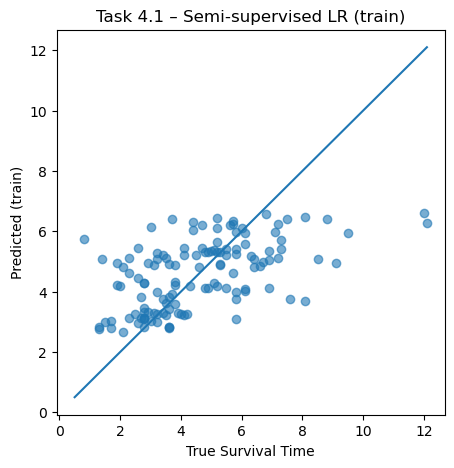

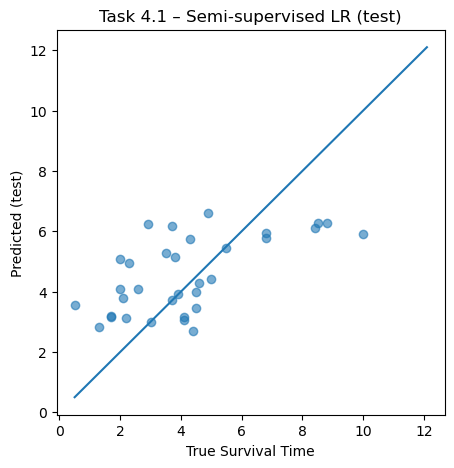


--- Training Isomap with n_components = 2 on ALL data ---

--- Training Isomap with n_components = 3 on ALL data ---

--- Training Isomap with n_components = 5 on ALL data ---

=== Task 4.1 – Semi-supervised Isomap + LR results ===
                            Model  Train_MSE  Train_RMSE   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE
Semi-supervised Isomap (n_comp=2)   3.950308    1.987538 4.195860 2.048380  4.419078   2.102160
Semi-supervised Isomap (n_comp=3)   3.603134    1.898192 3.902032 1.975356  3.986302   1.996573
Semi-supervised Isomap (n_comp=5)   3.450901    1.857660 3.858672 1.964350  4.406769   2.099230

Best semi-supervised Isomap model: n_components = 3
Test MSE:  3.9863
Test RMSE: 1.9966

=== Task 4.1 – Final comparison (semi-supervised models) ===
                Model  Train_MSE  Train_RMSE   CV_MSE  CV_RMSE  Test_MSE  Test_RMSE
          Semi-sup LR   3.034985    1.742121 3.730131 1.931355  3.386638   1.840282
Semi-sup Isomap (n=3)   3.603134    1.898192 3.902032 1.975356  

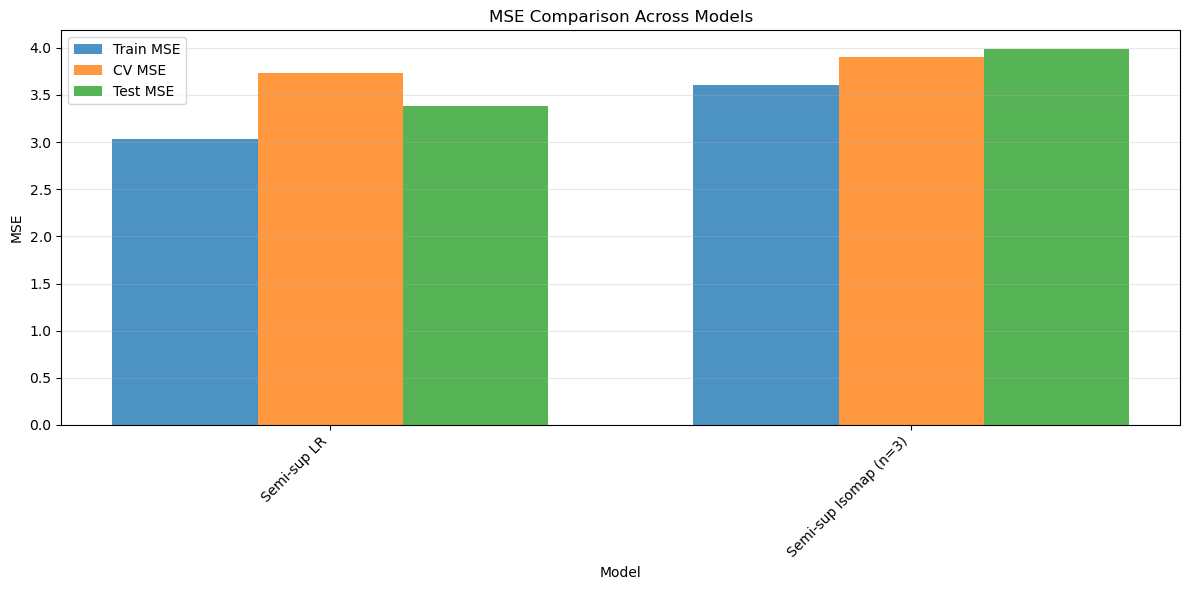

In [25]:
# ============================
# Task 4.1 - Semi-supervised
# ============================

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.manifold import Isomap
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline

print("\n==================== Task 4.1 - Imputation with labelled + unlabelled ====================\n")

# ------------------------------------------------------------------
# 1) Rebuild the best IMPUTER from Task 3.1 (but UNFITTED)
# ------------------------------------------------------------------
if best_strategy_name == "mean":
    semi_imputer = SimpleImputer(strategy="mean")
elif best_strategy_name == "median":
    semi_imputer = SimpleImputer(strategy="median")
elif best_strategy_name == "most_frequent":
    semi_imputer = SimpleImputer(strategy="most_frequent")
elif best_strategy_name == "constant_zero":
    semi_imputer = SimpleImputer(strategy="constant", fill_value=0.0)
elif best_strategy_name == "knn_5":
    semi_imputer = KNNImputer(n_neighbors=5, weights="uniform")
else:
    raise ValueError(f"Unknown best strategy: {best_strategy_name}")

# ------------------------------------------------------------------
# 2) Build LABELLED and UNLABELLED sets
#    - labelled = SurvivalTime not NaN AND Censored == 0
#    - unlabelled = all other rows
# ------------------------------------------------------------------
label_mask = (train["SurvivalTime"].notna()) & (train["Censored"] == 0)
unlabel_mask = ~label_mask

X_all_raw = train[full_feature_cols].values         # ALL patients
y_all = train["SurvivalTime"].values               # has NaNs for unlabeled
X_lab_raw_all = train.loc[label_mask, full_feature_cols].values
y_lab_all = train.loc[label_mask, "SurvivalTime"].values

print(f"Total rows (labelled + unlabelled): {X_all_raw.shape[0]}")
print(f"Labelled rows (for regression):     {X_lab_raw_all.shape[0]}")
print(f"Unlabelled rows:                    {X_all_raw.shape[0] - X_lab_raw_all.shape[0]}")

# ------------------------------------------------------------------
# 3) Fit IMPUTER and SCALER using ALL data (labelled + unlabelled)
# ------------------------------------------------------------------
semi_imputer.fit(X_all_raw)
X_all_imp = semi_imputer.transform(X_all_raw)

semi_scaler = StandardScaler(with_mean=True)
semi_scaler.fit(X_all_imp)

X_all_scaled = semi_scaler.transform(X_all_imp)
X_lab_scaled_all = X_all_scaled[label_mask]

# Train/test split only on LABELLED samples for evaluation
X_train_semi, X_test_semi, y_train_semi, y_test_semi = train_test_split(
    X_lab_scaled_all, y_lab_all, test_size=0.2, random_state=42
)

print("\nLabelled train size (Task 4.1):", len(X_train_semi))
print("Labelled test size   (Task 4.1):", len(X_test_semi))

# ------------------------------------------------------------------
# 4) Helper: FrozenTransformer for using pre-fitted transformers in a pipeline
# ------------------------------------------------------------------
class FrozenTransformer(BaseEstimator):
    def __init__(self, fitted_transformer):
        self.fitted_transformer = fitted_transformer

    def __getattr__(self, name):
        return getattr(self.fitted_transformer, name)

    def __sklearn_clone__(self):
        return self

    def fit(self, X, y=None):
        # Keep pre-fitted state
        return self

    def transform(self, X, y=None):
        return self.fitted_transformer.transform(X)

    def fit_transform(self, X, y=None):
        return self.fitted_transformer.transform(X)

# ------------------------------------------------------------------
# 5) Semi-supervised Linear Regression:
#    Imputer + scaler fitted on ALL data, LR trained only on labelled
# ------------------------------------------------------------------
semi_lr_pipe = make_pipeline(
    FrozenTransformer(semi_imputer),
    FrozenTransformer(semi_scaler),
    LinearRegression()
)

# For evaluation we pass RAW labelled features (pipe will impute/scale)
X_train_lab_raw, X_test_lab_raw, y_train_lab, y_test_lab = train_test_split(
    X_lab_raw_all, y_lab_all, test_size=0.2, random_state=42
)

results_lr_semi = evaluate_model_comprehensive(
    semi_lr_pipe,
    X_train_lab_raw, y_train_lab,
    X_test_lab_raw,  y_test_lab,
    model_name="Semi-supervised Linear Regression",
    cv=5,
    random_state=42
)

print("\n--- Task 4.1 – Semi-supervised Linear Regression ---")
for k, v in results_lr_semi.items():
    if k.startswith("Train_") or k.startswith("CV_") or k.startswith("Test_"):
        print(f"{k}: {v:.4f}")

# y–ŷ plots for semi-supervised LR
y_train_pred_lr = semi_lr_pipe.fit(X_train_lab_raw, y_train_lab).predict(X_train_lab_raw)
y_test_pred_lr  = semi_lr_pipe.predict(X_test_lab_raw)

plt.figure(figsize=(5,5))
plt.scatter(y_train_lab, y_train_pred_lr, alpha=0.6)
plt.plot([y_lab_all.min(), y_lab_all.max()], [y_lab_all.min(), y_lab_all.max()])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted (train)")
plt.title("Task 4.1 – Semi-supervised LR (train)")
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(y_test_lab, y_test_pred_lr, alpha=0.6)
plt.plot([y_lab_all.min(), y_lab_all.max()], [y_lab_all.min(), y_lab_all.max()])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted (test)")
plt.title("Task 4.1 – Semi-supervised LR (test)")
plt.show()

# ------------------------------------------------------------------
# 6) Semi-supervised Isomap + LR
#    Isomap fitted on ALL data (labelled + unlabelled)
# ------------------------------------------------------------------
n_components_list = [2, 3, 5]
iso_results_list = []
iso_models = {}

for n_comp in n_components_list:
    print(f"\n--- Training Isomap with n_components = {n_comp} on ALL data ---")
    
    iso = Isomap(n_components=n_comp)
    iso.fit(X_all_scaled)  # uses all patients (semi-supervised)
    
    iso_pipe = make_pipeline(
        FrozenTransformer(semi_imputer),
        FrozenTransformer(semi_scaler),
        FrozenTransformer(iso),
        LinearRegression()
    )
    
    res_iso = evaluate_model_comprehensive(
        iso_pipe,
        X_train_lab_raw, y_train_lab,
        X_test_lab_raw,  y_test_lab,
        model_name=f"Semi-supervised Isomap (n_comp={n_comp})",
        cv=5,
        random_state=42
    )
    
    iso_results_list.append(res_iso)
    iso_models[n_comp] = iso_pipe

iso_results_df = pd.DataFrame(iso_results_list)
print("\n=== Task 4.1 – Semi-supervised Isomap + LR results ===")
print(iso_results_df.to_string(index=False))

# Best Isomap model by Test_MSE
best_iso_row = iso_results_df.sort_values("Test_MSE").iloc[0]
best_n_comp = int(best_iso_row["Model"].split("=")[-1].strip(")"))
best_iso_model = iso_models[best_n_comp]

print(f"\nBest semi-supervised Isomap model: n_components = {best_n_comp}")
print(f"Test MSE:  {best_iso_row['Test_MSE']:.4f}")
print(f"Test RMSE: {best_iso_row['Test_RMSE']:.4f}")

# Final small comparison table LR vs best Isomap
models_41 = {
    "Semi-sup LR": semi_lr_pipe,
    f"Semi-sup Isomap (n={best_n_comp})": best_iso_model,
}

results_41_df, _ = compare_models(
    models_41,
    X_train_lab_raw, y_train_lab,
    X_test_lab_raw,  y_test_lab,
    cv=5,
    random_state=42
)

print("\n=== Task 4.1 – Final comparison (semi-supervised models) ===")
print(results_41_df.to_string(index=False))

plot_model_comparison(results_41_df, _, y_test_lab)

# Guardar algumas variáveis para a Task 4.2
X_labelled_semi = X_lab_raw_all          # raw labelled features
y_labelled_semi = y_lab_all
best_iso_model_41 = best_iso_model
best_iso_row_41 = best_iso_row
results_lr_semi_41 = results_lr_semi


<h2> Task 4.2 Imputation with labeled and unlabeled data </h2>

In [26]:
# ================================================
# Task 4.2 – Evaluation + Kaggle submission
# ================================================

import os

print("\n==================== Task 4.2 - Evaluation ====================\n")

# ------------------------------------------------------------
# 1. Build comparison table:
#    - Baseline + best imputation (Task 3.1)
#    - Best Task 3 model (from Task 3.3)
#    - Semi-supervised LR (Task 4.1)
#    - Semi-supervised Isomap + LR (Task 4.1)
# ------------------------------------------------------------

rows_4 = []

# 1.1 Baseline + best imputation (Task 3.1)
rows_4.append({
    "Model": f"Baseline + {best_strategy_name} (Task 3.1)",
    "Train_MSE": np.nan,
    "CV_MSE": best_stats_full["CV_MSE"],
    "Test_MSE": best_stats_full["Test_MSE"],
    "Train_RMSE": np.nan,
    "CV_RMSE": best_stats_full["CV_RMSE"],
    "Test_RMSE": best_stats_full["Test_RMSE"],
})

# 1.2 Best Task 3 model (from Task 3.3 global comparison)
rows_4.append({
    "Model": f"Best Task 3 model: {best_task3_name}",
    "Train_MSE": best_row_task3["Train_MSE"],
    "CV_MSE": best_row_task3["CV_MSE"],
    "Test_MSE": best_row_task3["Test_MSE"],
    "Train_RMSE": best_row_task3["Train_RMSE"],
    "CV_RMSE": best_row_task3["CV_RMSE"],
    "Test_RMSE": best_row_task3["Test_RMSE"],
})

# 1.3 Semi-supervised LR (Task 4.1)
rows_4.append({
    "Model": results_lr_semi_41["Model"],
    "Train_MSE": results_lr_semi_41["Train_MSE"],
    "CV_MSE": results_lr_semi_41["CV_MSE"],
    "Test_MSE": results_lr_semi_41["Test_MSE"],
    "Train_RMSE": results_lr_semi_41["Train_RMSE"],
    "CV_RMSE": results_lr_semi_41["CV_RMSE"],
    "Test_RMSE": results_lr_semi_41["Test_RMSE"],
})

# 1.4 Best semi-supervised Isomap + LR (Task 4.1)
rows_4.append({
    "Model": best_iso_row_41["Model"],
    "Train_MSE": best_iso_row_41["Train_MSE"],
    "CV_MSE": best_iso_row_41["CV_MSE"],
    "Test_MSE": best_iso_row_41["Test_MSE"],
    "Train_RMSE": best_iso_row_41["Train_RMSE"],
    "CV_RMSE": best_iso_row_41["CV_RMSE"],
    "Test_RMSE": best_iso_row_41["Test_RMSE"],
})

results_42_df = pd.DataFrame(rows_4)

print("=== Task 4.2 - Global comparison (Task 3 vs semi-supervised) ===")
print(results_42_df.to_string(index=False))

print("\n=== Ranking by Test_MSE (lower is better) ===")
ranking_42 = results_42_df.sort_values("Test_MSE").reset_index(drop=True)
ranking_42["Rank"] = ranking_42.index + 1
print(ranking_42[["Rank", "Model", "Test_MSE", "Test_RMSE"]].to_string(index=False))

# ------------------------------------------------------------
# 2. Kaggle submission – ALWAYS use semi-supervised Isomap
# ------------------------------------------------------------

print("\nFor the Kaggle submission of Task 4 we will ALWAYS use\n"
      "the best semi-supervised Isomap + LR model from Task 4.1.\n"
      "This guarantees that semisupervised-submission-02.csv is\n"
      "different from the handle-missing submissions of Task 3.\n")

# Train best semi-supervised Isomap model on ALL labelled data
best_iso_model_41.fit(X_labelled_semi, y_labelled_semi)

# Predict on the test set (the pipeline does imputation + scaling + Isomap)
X_test_semisup = test[full_feature_cols].values
test_pred_4 = best_iso_model_41.predict(X_test_semisup)

# Save submission
os.makedirs("../outputs/csv", exist_ok=True)

sub_4 = pd.DataFrame({
    "id": test["id"],
    "0": test_pred_4
})

output_path_4 = "../outputs/csv/semisupervised-submission-02.csv"
sub_4.to_csv(output_path_4, index=False)

print(f"Task 4 Kaggle submission saved to: {output_path_4}")
print("Upload this file as semisupervised-submission-02.csv on Kaggle.")



==================== Task 4.2 - Evaluation ====================

=== Task 4.2 - Global comparison (Task 3 vs semi-supervised) ===
                             Model  Train_MSE   CV_MSE  Test_MSE  Train_RMSE  CV_RMSE  Test_RMSE
        Baseline + mean (Task 3.1)        NaN 3.724064  3.385637         NaN 1.929783   1.840010
Best Task 3 model: Baseline + mean   3.035999 3.724064  3.385637    1.742412 1.929783   1.840010
 Semi-supervised Linear Regression   3.034985 3.730131  3.386638    1.742121 1.931355   1.840282
 Semi-supervised Isomap (n_comp=3)   3.603134 3.902032  3.986302    1.898192 1.975356   1.996573

=== Ranking by Test_MSE (lower is better) ===
 Rank                              Model  Test_MSE  Test_RMSE
    1         Baseline + mean (Task 3.1)  3.385637   1.840010
    2 Best Task 3 model: Baseline + mean  3.385637   1.840010
    3  Semi-supervised Linear Regression  3.386638   1.840282
    4  Semi-supervised Isomap (n_comp=3)  3.986302   1.996573

For the Kaggle submission 


==================== Task 5 – Ensemble HGB + CatBoost ====================

Task 5 – supervised rows: 161
Train size: 128,  Val size: 33

=== Task 5 – Validation results (Train/Val) ===
                          Model  Train_MSE  Train_RMSE  Val_MSE  Val_RMSE
                CatBoost (RMSE)   0.604691    0.777619 3.367956  1.835199
Ensemble 0.5*HGB + 0.5*CatBoost   1.038494    1.019065 3.549099  1.883905
 HistGradientBoosting + imputer   1.736459    1.317748 3.922908  1.980633

Best Task 5 model by Val_MSE: CatBoost (RMSE)


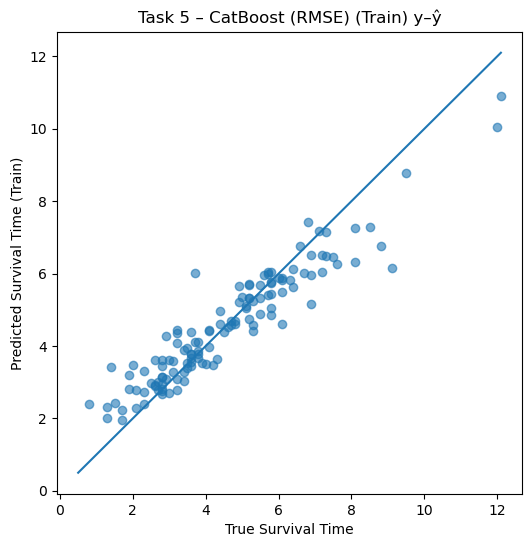

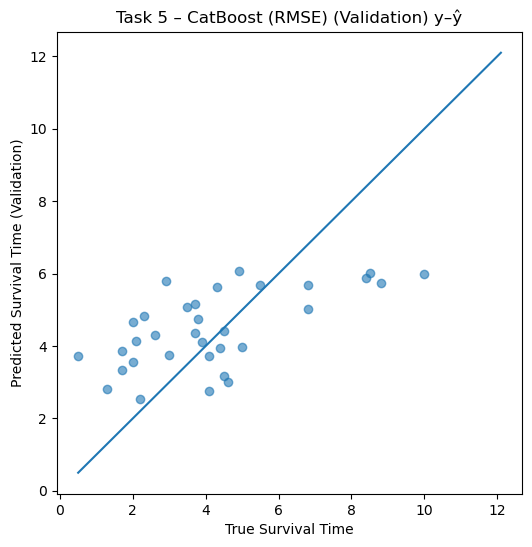


Task 5 – optional submission saved to: ../outputs/csv/optional-submission-01.csv
Upload this file to Kaggle as: optional-submission-01.csv


In [27]:
# ============================================
# Task 5 (optional) – Ensemble HGB + CatBoost
# optional-submission-01.csv
# ============================================

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

from catboost import CatBoostRegressor

print("\n==================== Task 5 – Ensemble HGB + CatBoost ====================\n")

# ------------------------------------------------------------------
# 1) Supervised dataset for Task 5
#    - use ALL patients with known SurvivalTime and not censored
# ------------------------------------------------------------------
supervised_mask_5 = (train["SurvivalTime"].notna()) & (train["Censored"] == 0)
train_sup_5 = train.loc[supervised_mask_5].copy()

X_sup_5 = train_sup_5[full_feature_cols].values
y_sup_5 = train_sup_5["SurvivalTime"].values

X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(
    X_sup_5, y_sup_5, test_size=0.2, random_state=42
)

print(f"Task 5 – supervised rows: {len(X_sup_5)}")
print(f"Train size: {len(X_train_5)},  Val size: {len(X_val_5)}")

# ------------------------------------------------------------------
# 2) Rebuild the BEST IMPUTER from Task 3.1 (UNFITTED)
# ------------------------------------------------------------------
if best_strategy_name == "mean":
    opt_imputer = SimpleImputer(strategy="mean")
elif best_strategy_name == "median":
    opt_imputer = SimpleImputer(strategy="median")
elif best_strategy_name == "most_frequent":
    opt_imputer = SimpleImputer(strategy="most_frequent")
elif best_strategy_name == "constant_zero":
    opt_imputer = SimpleImputer(strategy="constant", fill_value=0.0)
elif best_strategy_name == "knn_5":
    opt_imputer = KNNImputer(n_neighbors=5, weights="uniform")
else:
    raise ValueError(f"Unknown best strategy: {best_strategy_name}")

# ------------------------------------------------------------------
# 3) Define the two base models
# ------------------------------------------------------------------

# 3.1 HistGradientBoosting + best imputer (tree-based, handles non-linearities)
hgb_5 = make_pipeline(
    opt_imputer,
    HistGradientBoostingRegressor(
        max_iter=400,
        learning_rate=0.05,
        max_depth=None,
        l2_regularization=0.0,
        random_state=42
    )
)

# 3.2 CatBoostRegressor (RMSE) – directly on raw features (handles NaN)
cat_5 = CatBoostRegressor(
    loss_function="RMSE",
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3.0,
    random_seed=42,
    verbose=False
)

# ------------------------------------------------------------------
# 4) Train + evaluate each base model and the ensemble
# ------------------------------------------------------------------

# ---- HistGradientBoosting ----
hgb_5.fit(X_train_5, y_train_5)
y_train_hgb = hgb_5.predict(X_train_5)
y_val_hgb   = hgb_5.predict(X_val_5)

mse_train_hgb = mean_squared_error(y_train_5, y_train_hgb)
mse_val_hgb   = mean_squared_error(y_val_5,   y_val_hgb)

# ---- CatBoost ----
cat_5.fit(X_train_5, y_train_5, eval_set=(X_val_5, y_val_5))
y_train_cat = cat_5.predict(X_train_5)
y_val_cat   = cat_5.predict(X_val_5)

mse_train_cat = mean_squared_error(y_train_5, y_train_cat)
mse_val_cat   = mean_squared_error(y_val_5,   y_val_cat)

# ---- Simple averaging ENSEMBLE ----
y_train_ens = 0.5 * (y_train_hgb + y_train_cat)
y_val_ens   = 0.5 * (y_val_hgb   + y_val_cat)

mse_train_ens = mean_squared_error(y_train_5, y_train_ens)
mse_val_ens   = mean_squared_error(y_val_5,   y_val_ens)

# ------------------------------------------------------------------
# 5) Summary table for slides
# ------------------------------------------------------------------
results_task5 = pd.DataFrame([
    {
        "Model": "HistGradientBoosting + imputer",
        "Train_MSE": mse_train_hgb,
        "Train_RMSE": np.sqrt(mse_train_hgb),
        "Val_MSE": mse_val_hgb,
        "Val_RMSE": np.sqrt(mse_val_hgb),
    },
    {
        "Model": "CatBoost (RMSE)",
        "Train_MSE": mse_train_cat,
        "Train_RMSE": np.sqrt(mse_train_cat),
        "Val_MSE": mse_val_cat,
        "Val_RMSE": np.sqrt(mse_val_cat),
    },
    {
        "Model": "Ensemble 0.5*HGB + 0.5*CatBoost",
        "Train_MSE": mse_train_ens,
        "Train_RMSE": np.sqrt(mse_train_ens),
        "Val_MSE": mse_val_ens,
        "Val_RMSE": np.sqrt(mse_val_ens),
    },
])

print("\n=== Task 5 – Validation results (Train/Val) ===")
print(results_task5.sort_values("Val_MSE").to_string(index=False))

# ------------------------------------------------------------------
# 6) y–ŷ plots for the BEST model (usually the ensemble)
# ------------------------------------------------------------------
best_row_5 = results_task5.sort_values("Val_MSE").iloc[0]
best_name_5 = best_row_5["Model"]
print(f"\nBest Task 5 model by Val_MSE: {best_name_5}")

if "Ensemble" in best_name_5:
    y_train_best = y_train_ens
    y_val_best   = y_val_ens
elif "CatBoost" in best_name_5:
    y_train_best = y_train_cat
    y_val_best   = y_val_cat
else:
    y_train_best = y_train_hgb
    y_val_best   = y_val_hgb

plt.figure(figsize=(6,6))
plt.scatter(y_train_5, y_train_best, alpha=0.6)
a, b = y_sup_5.min(), y_sup_5.max()
plt.plot([a,b],[a,b])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Train)")
plt.title(f"Task 5 – {best_name_5} (Train) y–ŷ")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_val_5, y_val_best, alpha=0.6)
plt.plot([a,b],[a,b])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Validation)")
plt.title(f"Task 5 – {best_name_5} (Validation) y–ŷ")
plt.show()

# ------------------------------------------------------------------
# 7) Retrain BEST model on ALL supervised data and create Kaggle file
# ------------------------------------------------------------------

# Refit base models on ALL supervised data
hgb_5.fit(X_sup_5, y_sup_5)
cat_5.fit(X_sup_5, y_sup_5)

X_test_task5 = test[full_feature_cols].values

test_pred_hgb = hgb_5.predict(X_test_task5)
test_pred_cat = cat_5.predict(X_test_task5)
test_pred_ens = 0.5 * (test_pred_hgb + test_pred_cat)

# Choose which predictions to use for Kaggle (best model)
if "Ensemble" in best_name_5:
    test_pred_task5 = test_pred_ens
elif "CatBoost" in best_name_5:
    test_pred_task5 = test_pred_cat
else:
    test_pred_task5 = test_pred_hgb

# Save submission
os.makedirs("../outputs/csv", exist_ok=True)

sub_opt = pd.DataFrame({
    "id": test["id"],
    "0": test_pred_task5
})

opt_path = "../outputs/csv/optional-submission-01.csv"
sub_opt.to_csv(opt_path, index=False)

print(f"\nTask 5 – optional submission saved to: {opt_path}")
print("Upload this file to Kaggle as: optional-submission-01.csv")



==================== Task 5 – Tuned CatBoost ====================

Task 5 – supervised rows: 161
Train size: 128,  Val size: 33
Training combo 1/27: depth=4, lr=0.03, l2_leaf_reg=1.0
 -> Val MSE = 3.4298, Val RMSE = 1.8520
Training combo 2/27: depth=4, lr=0.03, l2_leaf_reg=3.0
 -> Val MSE = 3.2375, Val RMSE = 1.7993
Training combo 3/27: depth=4, lr=0.03, l2_leaf_reg=5.0
 -> Val MSE = 3.1668, Val RMSE = 1.7795
Training combo 4/27: depth=4, lr=0.05, l2_leaf_reg=1.0
 -> Val MSE = 3.4398, Val RMSE = 1.8547
Training combo 5/27: depth=4, lr=0.05, l2_leaf_reg=3.0
 -> Val MSE = 3.2277, Val RMSE = 1.7966
Training combo 6/27: depth=4, lr=0.05, l2_leaf_reg=5.0
 -> Val MSE = 3.1807, Val RMSE = 1.7835
Training combo 7/27: depth=4, lr=0.08, l2_leaf_reg=1.0
 -> Val MSE = 3.4207, Val RMSE = 1.8495
Training combo 8/27: depth=4, lr=0.08, l2_leaf_reg=3.0
 -> Val MSE = 3.3340, Val RMSE = 1.8259
Training combo 9/27: depth=4, lr=0.08, l2_leaf_reg=5.0
 -> Val MSE = 3.0834, Val RMSE = 1.7560
Training combo 1

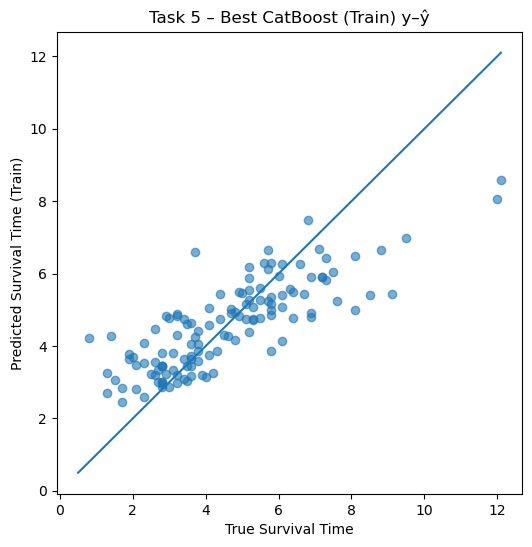

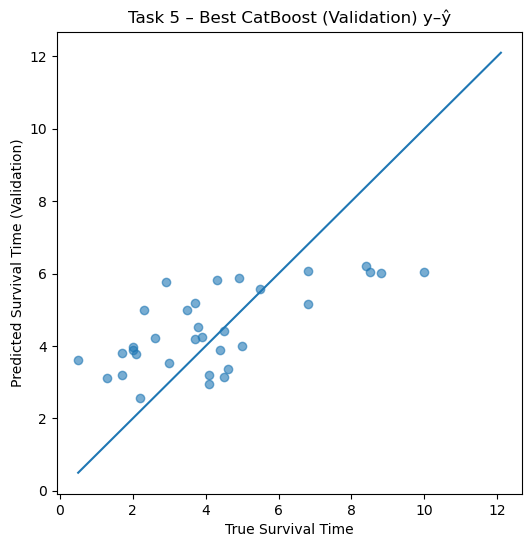


Retraining best CatBoost on ALL supervised data for final predictions...

Task 5 – optional submission saved to: ../outputs/csv/optional-submission-02.csv
Upload this file to Kaggle as: optional-submission-02.csv


In [28]:
# ============================================
# Task 5 – Tuned CatBoostRegressor (no ensemble)
# optional-submission-02.csv
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

print("\n==================== Task 5 – Tuned CatBoost ====================\n")

# ------------------------------------------------------------
# 1. Build supervised dataset for Task 5
#    Only use uncensored patients with known SurvivalTime
# ------------------------------------------------------------
supervised_mask_5 = (train["SurvivalTime"].notna()) & (train["Censored"] == 0)
train_sup_5 = train.loc[supervised_mask_5].copy()

X_sup_5 = train_sup_5[full_feature_cols].values
y_sup_5 = train_sup_5["SurvivalTime"].values

X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(
    X_sup_5, y_sup_5, test_size=0.2, random_state=42
)

print(f"Task 5 – supervised rows: {len(X_sup_5)}")
print(f"Train size: {len(X_train_5)},  Val size: {len(X_val_5)}")

# ------------------------------------------------------------
# 2. Hyperparameter search for CatBoostRegressor
#    We try a small grid of (depth, learning_rate, l2_leaf_reg)
# ------------------------------------------------------------
param_grid = {
    "depth":          [4, 6, 8],
    "learning_rate":  [0.03, 0.05, 0.08],
    "l2_leaf_reg":    [1.0, 3.0, 5.0],
}

results_params = []
best_mse = np.inf
best_model_5 = None
best_params = None

counter = 0
total = len(param_grid["depth"]) * len(param_grid["learning_rate"]) * len(param_grid["l2_leaf_reg"])

for d in param_grid["depth"]:
    for lr in param_grid["learning_rate"]:
        for l2 in param_grid["l2_leaf_reg"]:
            counter += 1
            print(f"Training combo {counter}/{total}: depth={d}, lr={lr}, l2_leaf_reg={l2}")

            # CatBoostRegressor with RMSE loss
            model = CatBoostRegressor(
                loss_function="RMSE",
                eval_metric="RMSE",
                iterations=1500,
                learning_rate=lr,
                depth=d,
                l2_leaf_reg=l2,
                random_seed=42,
                verbose=False
            )

            model.fit(X_train_5, y_train_5, eval_set=(X_val_5, y_val_5), verbose=False)

            y_val_pred = model.predict(X_val_5)
            mse_val = mean_squared_error(y_val_5, y_val_pred)
            rmse_val = np.sqrt(mse_val)

            results_params.append({
                "depth": d,
                "learning_rate": lr,
                "l2_leaf_reg": l2,
                "Val_MSE": mse_val,
                "Val_RMSE": rmse_val,
            })

            print(f" -> Val MSE = {mse_val:.4f}, Val RMSE = {rmse_val:.4f}")

            if mse_val < best_mse:
                best_mse = mse_val
                best_model_5 = model
                best_params = (d, lr, l2)

# Put all combinations into a DataFrame for the slides
results_params_df = pd.DataFrame(results_params).sort_values("Val_MSE")
print("\n=== Task 5 – CatBoost hyperparameter search results ===")
print(results_params_df.to_string(index=False))

print("\nBest params:")
print(f" depth        = {best_params[0]}")
print(f" learning_rate= {best_params[1]}")
print(f" l2_leaf_reg  = {best_params[2]}")
print(f" Best Val MSE = {best_mse:.4f}")
print(f" Best Val RMSE= {np.sqrt(best_mse):.4f}")

# ------------------------------------------------------------
# 3. y–ŷ plots for the best CatBoost model
# ------------------------------------------------------------
# Predictions on train and validation sets using best_model_5
y_train_best = best_model_5.predict(X_train_5)
y_val_best   = best_model_5.predict(X_val_5)

plt.figure(figsize=(6,6))
plt.scatter(y_train_5, y_train_best, alpha=0.6)
a, b = y_sup_5.min(), y_sup_5.max()
plt.plot([a,b],[a,b])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Train)")
plt.title("Task 5 – Best CatBoost (Train) y–ŷ")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_val_5, y_val_best, alpha=0.6)
plt.plot([a,b],[a,b])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Validation)")
plt.title("Task 5 – Best CatBoost (Validation) y–ŷ")
plt.show()

# ------------------------------------------------------------
# 4. Retrain best CatBoost on ALL supervised data
#    and generate Kaggle file optional-submission-02.csv
# ------------------------------------------------------------
print("\nRetraining best CatBoost on ALL supervised data for final predictions...")

best_depth, best_lr, best_l2 = best_params

final_cat_5 = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    iterations=1500,
    learning_rate=best_lr,
    depth=best_depth,
    l2_leaf_reg=best_l2,
    random_seed=42,
    verbose=False
)

final_cat_5.fit(X_sup_5, y_sup_5)

X_test_5 = test[full_feature_cols].values
test_pred_5 = final_cat_5.predict(X_test_5)

# Save submission
os.makedirs("../outputs/csv", exist_ok=True)

sub_opt2 = pd.DataFrame({
    "id": test["id"],
    "0": test_pred_5
})

opt_path2 = "../outputs/csv/optional-submission-02.csv"
sub_opt2.to_csv(opt_path2, index=False)

print(f"\nTask 5 – optional submission saved to: {opt_path2}")
print("Upload this file to Kaggle as: optional-submission-02.csv")



==================== Task 5 – Tuned MLPRegressor ====================

Total supervised rows (Task 5 / MLP): 161
Train size: 128,  Val size: 33
Using best imputation strategy from Task 3.1: mean
MLP combo 1/18: hls=(50,), alpha=1e-05, lr=0.001
 -> Val MSE = 3.7384, Val RMSE = 1.9335
MLP combo 2/18: hls=(50,), alpha=1e-05, lr=0.01
 -> Val MSE = 3.9892, Val RMSE = 1.9973
MLP combo 3/18: hls=(50,), alpha=0.0001, lr=0.001
 -> Val MSE = 3.7373, Val RMSE = 1.9332
MLP combo 4/18: hls=(50,), alpha=0.0001, lr=0.01
 -> Val MSE = 3.9892, Val RMSE = 1.9973
MLP combo 5/18: hls=(50,), alpha=0.001, lr=0.001
 -> Val MSE = 3.7371, Val RMSE = 1.9332
MLP combo 6/18: hls=(50,), alpha=0.001, lr=0.01
 -> Val MSE = 3.9891, Val RMSE = 1.9973
MLP combo 7/18: hls=(100,), alpha=1e-05, lr=0.001
 -> Val MSE = 4.2809, Val RMSE = 2.0690
MLP combo 8/18: hls=(100,), alpha=1e-05, lr=0.01
 -> Val MSE = 3.9661, Val RMSE = 1.9915
MLP combo 9/18: hls=(100,), alpha=0.0001, lr=0.001
 -> Val MSE = 4.2809, Val RMSE = 2.0690
M

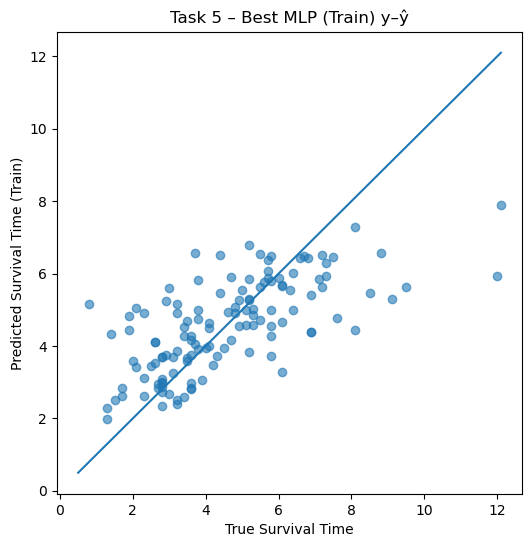

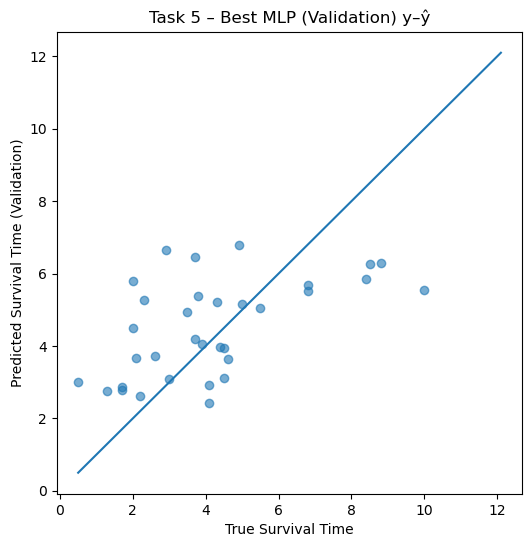


Retraining best MLP on ALL supervised data for final predictions...

Task 5 – MLP submission saved to: ../outputs/csv/optional-submission-03.csv
Upload this file to Kaggle as: optional-submission-03.csv


c:\Users\DESKTOP\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [29]:
# ============================================
# Task 5 – Tuned MLPRegressor (neural network)
# optional-submission-03.csv
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler

print("\n==================== Task 5 – Tuned MLPRegressor ====================\n")

# ------------------------------------------------------------
# 1. Build supervised dataset for Task 5
#    Only uncensored patients with known SurvivalTime
# ------------------------------------------------------------
supervised_mask_5 = (train["SurvivalTime"].notna()) & (train["Censored"] == 0)
train_sup_5 = train.loc[supervised_mask_5].copy()

X_raw_5 = train_sup_5[full_feature_cols].values
y_5 = train_sup_5["SurvivalTime"].values

print(f"Total supervised rows (Task 5 / MLP): {len(X_raw_5)}")

# ------------------------------------------------------------
# 2. Train/validation split (on RAW features)
# ------------------------------------------------------------
X_train_raw_5, X_val_raw_5, y_train_5, y_val_5 = train_test_split(
    X_raw_5, y_5, test_size=0.2, random_state=42
)

print(f"Train size: {len(X_train_raw_5)},  Val size: {len(X_val_raw_5)}")

# ------------------------------------------------------------
# 3. Build the IMPUTER using best_strategy_name (from Task 3.1)
#    If it does not exist, fallback to SimpleImputer(mean)
# ------------------------------------------------------------
if "best_strategy_name" in globals():
    print(f"Using best imputation strategy from Task 3.1: {best_strategy_name}")
    if best_strategy_name == "mean":
        mlp_imputer = SimpleImputer(strategy="mean")
    elif best_strategy_name == "median":
        mlp_imputer = SimpleImputer(strategy="median")
    elif best_strategy_name == "most_frequent":
        mlp_imputer = SimpleImputer(strategy="most_frequent")
    elif best_strategy_name == "constant_zero":
        mlp_imputer = SimpleImputer(strategy="constant", fill_value=0.0)
    elif best_strategy_name == "knn_5":
        mlp_imputer = KNNImputer(n_neighbors=5, weights="uniform")
    else:
        print("Unknown best_strategy_name, falling back to mean imputer.")
        mlp_imputer = SimpleImputer(strategy="mean")
else:
    print("best_strategy_name not found – falling back to mean imputer.")
    mlp_imputer = SimpleImputer(strategy="mean")

# Fit imputer on TRAIN only, then transform train and val
X_train_imp_5 = mlp_imputer.fit_transform(X_train_raw_5)
X_val_imp_5   = mlp_imputer.transform(X_val_raw_5)

# ------------------------------------------------------------
# 4. StandardScaler (very important for MLP!)
# ------------------------------------------------------------
mlp_scaler = StandardScaler(with_mean=True)
X_train_scaled_5 = mlp_scaler.fit_transform(X_train_imp_5)
X_val_scaled_5   = mlp_scaler.transform(X_val_imp_5)

# ------------------------------------------------------------
# 5. Hyperparameter search for MLPRegressor
# ------------------------------------------------------------
param_grid_mlp = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50)],
    "alpha": [1e-5, 1e-4, 1e-3],
    "learning_rate_init": [0.001, 0.01],
}

results_mlp = []
best_mse_mlp = np.inf
best_mlp = None
best_params_mlp = None

counter = 0
total = (
    len(param_grid_mlp["hidden_layer_sizes"]) *
    len(param_grid_mlp["alpha"]) *
    len(param_grid_mlp["learning_rate_init"])
)

for hls in param_grid_mlp["hidden_layer_sizes"]:
    for alpha in param_grid_mlp["alpha"]:
        for lr_init in param_grid_mlp["learning_rate_init"]:
            counter += 1
            print(f"MLP combo {counter}/{total}: "
                  f"hls={hls}, alpha={alpha}, lr={lr_init}")

            mlp = MLPRegressor(
                hidden_layer_sizes=hls,
                activation="relu",
                solver="adam",
                alpha=alpha,
                learning_rate_init=lr_init,
                max_iter=2000,
                random_state=42,
                early_stopping=True,
                n_iter_no_change=30,
                verbose=False
            )

            mlp.fit(X_train_scaled_5, y_train_5)

            y_val_pred_5 = mlp.predict(X_val_scaled_5)
            mse_val_5 = mean_squared_error(y_val_5, y_val_pred_5)
            rmse_val_5 = np.sqrt(mse_val_5)

            results_mlp.append({
                "hidden_layer_sizes": hls,
                "alpha": alpha,
                "learning_rate_init": lr_init,
                "Val_MSE": mse_val_5,
                "Val_RMSE": rmse_val_5,
            })

            print(f" -> Val MSE = {mse_val_5:.4f}, Val RMSE = {rmse_val_5:.4f}")

            if mse_val_5 < best_mse_mlp:
                best_mse_mlp = mse_val_5
                best_mlp = mlp
                best_params_mlp = (hls, alpha, lr_init)

# Tabela com resultados do MLP (para os slides)
results_mlp_df = pd.DataFrame(results_mlp).sort_values("Val_MSE")
print("\n=== Task 5 – MLP hyperparameter search results ===")
print(results_mlp_df.to_string(index=False))

print("\nBest MLP params:")
print(f" hidden_layer_sizes = {best_params_mlp[0]}")
print(f" alpha              = {best_params_mlp[1]}")
print(f" learning_rate_init = {best_params_mlp[2]}")
print(f" Best Val MSE       = {best_mse_mlp:.4f}")
print(f" Best Val RMSE      = {np.sqrt(best_mse_mlp):.4f}")

# ------------------------------------------------------------
# 6. y–ŷ plots for best MLP (train & val)
# ------------------------------------------------------------
y_train_best_mlp = best_mlp.predict(X_train_scaled_5)
y_val_best_mlp   = best_mlp.predict(X_val_scaled_5)

a, b = y_5.min(), y_5.max()

plt.figure(figsize=(6,6))
plt.scatter(y_train_5, y_train_best_mlp, alpha=0.6)
plt.plot([a,b],[a,b])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Train)")
plt.title("Task 5 – Best MLP (Train) y–ŷ")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_val_5, y_val_best_mlp, alpha=0.6)
plt.plot([a,b],[a,b])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (Validation)")
plt.title("Task 5 – Best MLP (Validation) y–ŷ")
plt.show()

# ------------------------------------------------------------
# 7. Retrain best MLP on ALL supervised data and predict test
# ------------------------------------------------------------
print("\nRetraining best MLP on ALL supervised data for final predictions...")

# Refit imputer & scaler on ALL supervised rows
X_imp_all_5 = mlp_imputer.fit_transform(X_raw_5)
X_scaled_all_5 = mlp_scaler.fit_transform(X_imp_all_5)

# Rebuild MLP with best params and fit on ALL data
best_hls, best_alpha, best_lr_init = best_params_mlp

final_mlp_5 = MLPRegressor(
    hidden_layer_sizes=best_hls,
    activation="relu",
    solver="adam",
    alpha=best_alpha,
    learning_rate_init=best_lr_init,
    max_iter=2000,
    random_state=42,
    early_stopping=False,   # agora treinamos até ao fim, em todos os dados
    verbose=False
)

final_mlp_5.fit(X_scaled_all_5, y_5)

# Transform test set with same imputer & scaler
X_test_raw_5 = test[full_feature_cols].values
X_test_imp_5 = mlp_imputer.transform(X_test_raw_5)
X_test_scaled_5 = mlp_scaler.transform(X_test_imp_5)

test_pred_mlp_5 = final_mlp_5.predict(X_test_scaled_5)

# ------------------------------------------------------------
# 8. Save Kaggle submission: optional-submission-03.csv
# ------------------------------------------------------------
os.makedirs("../outputs/csv", exist_ok=True)

sub_opt3 = pd.DataFrame({
    "id": test["id"],
    "0": test_pred_mlp_5
})

opt_path3 = "../outputs/csv/optional-submission-03.csv"
sub_opt3.to_csv(opt_path3, index=False)

print(f"\nTask 5 – MLP submission saved to: {opt_path3}")
print("Upload this file to Kaggle as: optional-submission-03.csv")


In [30]:
# ==============================
# Task 5 – XGBoost final model
# ==============================
from xgboost import XGBRegressor
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import os

print("\n==================== Task 5 – XGBoost ====================\n")

# ------------------------------------------------------------
# 1. Build supervised dataset for Task 5
#    - Use all patients with known SurvivalTime and not censored
# ------------------------------------------------------------
supervised_mask_5 = (train["SurvivalTime"].notna()) & (train["Censored"] == 0)
train_5 = train.loc[supervised_mask_5].copy()

X_raw_5 = train_5[full_feature_cols].values
y_5 = train_5["SurvivalTime"].values

X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(
    X_raw_5, y_5, test_size=0.2, random_state=42
)

print("Task 5 – Train size:", len(X_train_5))
print("Task 5 – Val size:  ", len(X_val_5))

# ------------------------------------------------------------
# 2. Hyperparameter grid for XGBoost
#    (podes afinar/encurtar se ficar muito lento)
# ------------------------------------------------------------
param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.03, 0.05, 0.1],
    "n_estimators": [200, 400, 800],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "reg_lambda": [0.0, 1.0, 5.0],
}

keys = list(param_grid.keys())
all_combos = [dict(zip(keys, v)) for v in product(*param_grid.values())]

print(f"Número total de combinações: {len(all_combos)}")

best_rmse = np.inf
best_params_xgb = None

# ------------------------------------------------------------
# 3. Manual grid search
# ------------------------------------------------------------
for i, params in enumerate(all_combos, start=1):
    print(f"\nCombo {i}/{len(all_combos)}: {params}")

    model = XGBRegressor(
        objective="reg:squarederror",
        max_depth=params["max_depth"],
        learning_rate=params["learning_rate"],
        n_estimators=params["n_estimators"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        reg_lambda=params["reg_lambda"],
        tree_method="hist",   # rápido e estável em CPU
        random_state=42,
        n_jobs=-1,
        eval_metric="rmse"    # <- AQUI, não no fit()
    )

    # Versões antigas do XGBoost não aceitam eval_metric no fit()
    model.fit(
        X_train_5,
        y_train_5,
        eval_set=[(X_val_5, y_val_5)],
        verbose=False
    )

    y_val_pred = model.predict(X_val_5)
    mse_val = mean_squared_error(y_val_5, y_val_pred)
    rmse_val = np.sqrt(mse_val)

    print(f"  -> Val RMSE = {rmse_val:.4f}")

    if rmse_val < best_rmse:
        best_rmse = rmse_val
        best_params_xgb = params.copy()
        print(f"  ** New best RMSE! {best_rmse:.4f}")

print("\nBest XGBoost parameters:")
print(best_params_xgb)
print(f"Best validation RMSE: {best_rmse:.4f}")

# ------------------------------------------------------------
# 4. Train final XGBoost model on ALL supervised data
# ------------------------------------------------------------
final_xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
    eval_metric="rmse",
    **best_params_xgb
)

final_xgb.fit(X_raw_5, y_5)

# ------------------------------------------------------------
# 5. Predict on Kaggle test set
# ------------------------------------------------------------
X_test_5 = test[full_feature_cols].values
test_pred_xgb = final_xgb.predict(X_test_5)

# ------------------------------------------------------------
# 6. Save Kaggle submission for Task 5
# ------------------------------------------------------------
os.makedirs("../outputs/csv", exist_ok=True)

sub_xgb = pd.DataFrame({
    "id": test["id"],
    "0": test_pred_xgb
})

output_path = "../outputs/csv/optional-submission-01.csv"
sub_xgb.to_csv(output_path, index=False)

print(f"\nTask 5 XGBoost submission saved to: {output_path}")
print("Submete este ficheiro como: optional-submission-01.csv no Kaggle.")



==================== Task 5 – XGBoost ====================

Task 5 – Train size: 128
Task 5 – Val size:   33
Número total de combinações: 729

Combo 1/729: {'max_depth': 3, 'learning_rate': 0.03, 'n_estimators': 200, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_lambda': 0.0}
  -> Val RMSE = 1.9619
  ** New best RMSE! 1.9619

Combo 2/729: {'max_depth': 3, 'learning_rate': 0.03, 'n_estimators': 200, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_lambda': 1.0}
  -> Val RMSE = 1.8828
  ** New best RMSE! 1.8828

Combo 3/729: {'max_depth': 3, 'learning_rate': 0.03, 'n_estimators': 200, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_lambda': 5.0}
  -> Val RMSE = 1.8469
  ** New best RMSE! 1.8469

Combo 4/729: {'max_depth': 3, 'learning_rate': 0.03, 'n_estimators': 200, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_lambda': 0.0}
  -> Val RMSE = 1.9583

Combo 5/729: {'max_depth': 3, 'learning_rate': 0.03, 'n_estimators': 200, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_lambda': 1.0}

In [31]:
# ==============================
# Task 5 – CatBoost final model
# ==============================
import numpy as np
import pandas as pd
import os

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

print("\n==================== Task 5 – CatBoost ====================\n")

# ------------------------------------------------------------
# 0. Safety checks / fallbacks
# ------------------------------------------------------------
if "full_feature_cols" not in globals():
    full_feature_cols = [
        "Age", "Gender", "Stage", "GeneticRisk",
        "TreatmentType", "ComorbidityIndex", "TreatmentResponse"
    ]
    print("Warning: full_feature_cols was not defined. Using default list.")

# If best_imputer from Task 3.1 is not available, fall back to median imputer
if "best_imputer" not in globals():
    print("Warning: best_imputer not found. Using SimpleImputer(strategy='median') as fallback.")
    best_imputer = SimpleImputer(strategy="median")

# ------------------------------------------------------------
# 1. Build supervised dataset for Task 5
#    - Use same logic as Task 3.1 (Censored == 0, SurvivalTime not NaN)
# ------------------------------------------------------------
supervised_mask_5 = (train["Censored"] == 0) & train["SurvivalTime"].notna()
train_5 = train.loc[supervised_mask_5].copy()

X_5 = train_5[full_feature_cols].values
y_5 = train_5["SurvivalTime"].values

# Impute missing values using best_imputer on ALL supervised data
X_5_imp = best_imputer.fit_transform(X_5)

X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(
    X_5_imp, y_5, test_size=0.2, random_state=42
)

print("Task 5 – Train size:", len(X_train_5))
print("Task 5 – Val size:  ", len(X_val_5))

# ------------------------------------------------------------
# 2. Small but strong hyperparameter search for CatBoost
# ------------------------------------------------------------
param_grid = {
    "depth":        [4, 6, 8],
    "learning_rate":[0.03, 0.06],
    "n_estimators": [600, 1000],
    "l2_leaf_reg":  [3, 10],
    "subsample":    [0.8, 1.0],
}

from itertools import product
keys = list(param_grid.keys())
all_combos = [dict(zip(keys, v)) for v in product(*param_grid.values())]

print(f"Total hyperparameter combinations: {len(all_combos)}")

best_rmse = np.inf
best_params_cb = None

for i, params in enumerate(all_combos, start=1):
    print(f"\nCombo {i}/{len(all_combos)}: {params}")

    model = CatBoostRegressor(
        loss_function="RMSE",
        eval_metric="RMSE",
        depth=params["depth"],
        learning_rate=params["learning_rate"],
        n_estimators=params["n_estimators"],
        l2_leaf_reg=params["l2_leaf_reg"],
        subsample=params["subsample"],
        random_state=42,
        verbose=False
    )

    model.fit(
        X_train_5, y_train_5,
        eval_set=(X_val_5, y_val_5),
        verbose=False
    )

    y_val_pred = model.predict(X_val_5)
    mse_val = mean_squared_error(y_val_5, y_val_pred)
    rmse_val = np.sqrt(mse_val)

    print(f"  -> Val RMSE = {rmse_val:.4f}")

    if rmse_val < best_rmse:
        best_rmse = rmse_val
        best_params_cb = params.copy()
        print(f"  ** New best RMSE! {best_rmse:.4f}")

print("\nBest CatBoost parameters:")
print(best_params_cb)
print(f"Best validation RMSE: {best_rmse:.4f}")

# ------------------------------------------------------------
# 3. Train final CatBoost model on ALL supervised data
#    (with imputation fitted on ALL supervised X_5)
# ------------------------------------------------------------
# Refit imputer on all supervised examples
best_imputer.fit(X_5)
X_5_imp_all = best_imputer.transform(X_5)

final_cb = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    depth=best_params_cb["depth"],
    learning_rate=best_params_cb["learning_rate"],
    n_estimators=best_params_cb["n_estimators"],
    l2_leaf_reg=best_params_cb["l2_leaf_reg"],
    subsample=best_params_cb["subsample"],
    random_state=42,
    verbose=False
)

final_cb.fit(X_5_imp_all, y_5)

# ------------------------------------------------------------
# 4. Predict on Kaggle test set
# ------------------------------------------------------------
X_test_5 = test[full_feature_cols].values
X_test_5_imp = best_imputer.transform(X_test_5)

test_pred_cb = final_cb.predict(X_test_5_imp)

# ------------------------------------------------------------
# 5. Save Kaggle submission for Task 5
# ------------------------------------------------------------
os.makedirs("../outputs/csv", exist_ok=True)

sub_cb = pd.DataFrame({
    "id": test["id"],
    "0": test_pred_cb
})

output_path_cb = "../outputs/csv/optional-submission-02.csv"
sub_cb.to_csv(output_path_cb, index=False)

print(f"\nTask 5 CatBoost submission saved to: {output_path_cb}")
print("Submete este ficheiro como: optional-submission-02.csv no Kaggle.")



==================== Task 5 – CatBoost ====================

Task 5 – Train size: 128
Task 5 – Val size:   33
Total hyperparameter combinations: 48

Combo 1/48: {'depth': 4, 'learning_rate': 0.03, 'n_estimators': 600, 'l2_leaf_reg': 3, 'subsample': 0.8}
  -> Val RMSE = 1.8600
  ** New best RMSE! 1.8600

Combo 2/48: {'depth': 4, 'learning_rate': 0.03, 'n_estimators': 600, 'l2_leaf_reg': 3, 'subsample': 1.0}
  -> Val RMSE = 1.8513
  ** New best RMSE! 1.8513

Combo 3/48: {'depth': 4, 'learning_rate': 0.03, 'n_estimators': 600, 'l2_leaf_reg': 10, 'subsample': 0.8}
  -> Val RMSE = 1.8399
  ** New best RMSE! 1.8399

Combo 4/48: {'depth': 4, 'learning_rate': 0.03, 'n_estimators': 600, 'l2_leaf_reg': 10, 'subsample': 1.0}
  -> Val RMSE = 1.8363
  ** New best RMSE! 1.8363

Combo 5/48: {'depth': 4, 'learning_rate': 0.03, 'n_estimators': 1000, 'l2_leaf_reg': 3, 'subsample': 0.8}
  -> Val RMSE = 1.8600

Combo 6/48: {'depth': 4, 'learning_rate': 0.03, 'n_estimators': 1000, 'l2_leaf_reg': 3, 'subsa

In [32]:
# ================================================
# Task 5 – Stacking ensemble (HGB + CatBoost + LR + XGB)
# ================================================
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor

# Optional: XGBoost
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
    print("XGBoost found – will include it in the ensemble.")
except ImportError:
    HAS_XGB = False
    print("XGBoost NOT found – ensemble will skip XGBRegressor.")

# CatBoost
from catboost import CatBoostRegressor

print("\n==================== Task 5 – Stacking ensemble ====================\n")

# ------------------------------------------------------------
# 0. Safety checks / fallbacks
# ------------------------------------------------------------
# Feature list
if "full_feature_cols" not in globals():
    full_feature_cols = [
        "Age", "Gender", "Stage", "GeneticRisk",
        "TreatmentType", "ComorbidityIndex", "TreatmentResponse"
    ]
    print("Warning: full_feature_cols was not defined. Using default list.")

# Best imputer from Task 3.1
from sklearn.impute import SimpleImputer, KNNImputer
if "best_imputer" not in globals():
    print("Warning: best_imputer not found. Using SimpleImputer(strategy='median') as fallback.")
    best_imputer = SimpleImputer(strategy="median")

# ------------------------------------------------------------
# 1. Build supervised dataset for Task 5
#    (same logic as Task 3.1: Censored == 0 and SurvivalTime not NaN)
# ------------------------------------------------------------
supervised_mask_5 = (train["Censored"] == 0) & train["SurvivalTime"].notna()
train_5 = train.loc[supervised_mask_5].copy()

X_5_raw = train_5[full_feature_cols].values
y_5 = train_5["SurvivalTime"].values

print("Total supervised rows (Task 5):", X_5_raw.shape[0])

# Impute missing values using best_imputer on ALL supervised data
X_5_imp = best_imputer.fit_transform(X_5_raw)

# For a quick local check, keep a small validation split
X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(
    X_5_imp, y_5, test_size=0.2, random_state=42
)
print("Train size for quick val:", len(X_train_5))
print("Val size for quick val:  ", len(X_val_5))

# ------------------------------------------------------------
# 2. Define base learners
# ------------------------------------------------------------
base_models = {}

# HistGradientBoosting – strong tree-based model
base_models["hgb"] = HistGradientBoostingRegressor(
    max_iter=500,
    learning_rate=0.05,
    max_depth=None,
    l2_regularization=0.0,
    random_state=42
)

# CatBoost – good for tabular data
base_models["cb"] = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    depth=6,
    learning_rate=0.05,
    n_estimators=800,
    l2_leaf_reg=3.0,
    subsample=0.9,
    random_state=42,
    verbose=False
)

# Linear Regression – simple but captures global linear trend
base_models["lr"] = LinearRegression()

# Optional XGBRegressor
if HAS_XGB:
    base_models["xgb"] = XGBRegressor(
        objective="reg:squarederror",
        max_depth=4,
        learning_rate=0.05,
        n_estimators=800,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        n_jobs=-1
    )

print("Base models in the ensemble:", list(base_models.keys()))

# ------------------------------------------------------------
# 3. Stacking: out-of-fold predictions for meta-learner
# ------------------------------------------------------------
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

n_samples = X_5_imp.shape[0]
n_models = len(base_models)

# OOF predictions matrix: shape (n_samples, n_models)
oof_preds = np.zeros((n_samples, n_models))
model_names = list(base_models.keys())

print("\nBuilding out-of-fold predictions for stacking...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_5_imp, y_5), start=1):
    print(f"\nFold {fold}/{n_splits}")
    X_tr, X_v = X_5_imp[train_idx], X_5_imp[val_idx]
    y_tr, y_v = y_5[train_idx], y_5[val_idx]

    for j, name in enumerate(model_names):
        print(f"  Training base model: {name}")
        m = base_models[name]

        # For CatBoost we pass eval_set for a bit of internal early stopping / monitoring
        if name == "cb":
            m.fit(X_tr, y_tr, eval_set=(X_v, y_v), verbose=False)
        else:
            m.fit(X_tr, y_tr)

        y_v_pred = m.predict(X_v)
        oof_preds[val_idx, j] = y_v_pred

# Evaluate stacking base level (OOF) performance with a simple average
avg_oof = oof_preds.mean(axis=1)
mse_oof_avg = mean_squared_error(y_5, avg_oof)
rmse_oof_avg = np.sqrt(mse_oof_avg)
print(f"\nOOF average of base models – RMSE: {rmse_oof_avg:.4f}")

# ------------------------------------------------------------
# 4. Train meta-learner on OOF predictions
# ------------------------------------------------------------
# Use Ridge regression as meta-model (usually better than plain LR)
meta_model = Ridge(alpha=1.0, random_state=42)

meta_model.fit(oof_preds, y_5)

# Quick local check on the hold-out validation split
# (using the same imputed X_train_5 / X_val_5)
base_val_preds = np.zeros((X_val_5.shape[0], n_models))
for j, name in enumerate(model_names):
    # Refit each base model on ALL supervised data before validation
    print(f"Refitting base model on all data for val: {name}")
    m_full = base_models[name]
    m_full.fit(X_5_imp, y_5)
    base_val_preds[:, j] = m_full.predict(X_val_5)

y_val_stack = meta_model.predict(base_val_preds)
mse_val_stack = mean_squared_error(y_val_5, y_val_stack)
rmse_val_stack = np.sqrt(mse_val_stack)
print(f"\nStacking ensemble – validation RMSE (20% holdout): {rmse_val_stack:.4f}")

# ------------------------------------------------------------
# 5. Train final ensemble on ALL supervised data
# ------------------------------------------------------------
print("\nTraining final ensemble on ALL supervised data...")

# Refit base models on ALL supervised data
final_base_models = {}
for name in model_names:
    print(f"  Fitting final base model: {name}")
    m = base_models[name]
    m.fit(X_5_imp, y_5)
    final_base_models[name] = m

# Meta-model is already trained on OOF (which uses all samples),
# we keep it as is.
# (You could refit on base models' predictions on ALL data, but OOF is usually safer.)

# ------------------------------------------------------------
# 6. Predict on Kaggle test set
# ------------------------------------------------------------
X_test_raw_5 = test[full_feature_cols].values
X_test_imp_5 = best_imputer.transform(X_test_raw_5)

# Base predictions on test
base_test_preds = np.zeros((X_test_imp_5.shape[0], n_models))
for j, name in enumerate(model_names):
    print(f"  Predicting test with base model: {name}")
    base_test_preds[:, j] = final_base_models[name].predict(X_test_imp_5)

# Meta prediction
test_pred_5 = meta_model.predict(base_test_preds)

# ------------------------------------------------------------
# 7. Save Kaggle submission for Task 5
# ------------------------------------------------------------
os.makedirs("../outputs/csv", exist_ok=True)

sub_ensemble = pd.DataFrame({
    "id": test["id"],
    "0": test_pred_5
})

output_path_5 = "../outputs/csv/optional-submission-04.csv"
sub_ensemble.to_csv(output_path_5, index=False)

print(f"\nTask 5 stacking submission saved to: {output_path_5}")
print("Submete este ficheiro como: optional-submission-04.csv no Kaggle.")


XGBoost found – will include it in the ensemble.

==================== Task 5 – Stacking ensemble ====================

Total supervised rows (Task 5): 161
Train size for quick val: 128
Val size for quick val:   33
Base models in the ensemble: ['hgb', 'cb', 'lr', 'xgb']

Building out-of-fold predictions for stacking...

Fold 1/5
  Training base model: hgb
  Training base model: cb
  Training base model: lr
  Training base model: xgb

Fold 2/5
  Training base model: hgb
  Training base model: cb
  Training base model: lr
  Training base model: xgb

Fold 3/5
  Training base model: hgb
  Training base model: cb
  Training base model: lr
  Training base model: xgb

Fold 4/5
  Training base model: hgb
  Training base model: cb
  Training base model: lr
  Training base model: xgb

Fold 5/5
  Training base model: hgb
  Training base model: cb
  Training base model: lr
  Training base model: xgb

OOF average of base models – RMSE: 1.8845
Refitting base model on all data for val: hgb
Refitting 

In [33]:
# ================================================
# Task 5 – ExtraTreesRegressor (optional)
# Gera: optional-submission-05.csv
# ================================================
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer, KNNImputer

print("\n==================== Task 5 – ExtraTreesRegressor ====================\n")

# ------------------------------------------------------------
# 0. Safety checks / fallbacks
# ------------------------------------------------------------

# full_feature_cols (same as in Tasks 3/4)
if "full_feature_cols" not in globals():
    full_feature_cols = [
        "Age", "Gender", "Stage", "GeneticRisk",
        "TreatmentType", "ComorbidityIndex", "TreatmentResponse"
    ]
    print("Warning: full_feature_cols was not defined. Using default list.")

# best_imputer from Task 3.1 (if not available, use median)
if "best_imputer" not in globals():
    print("Warning: best_imputer not found. Using SimpleImputer(strategy='median') as fallback.")
    best_imputer = SimpleImputer(strategy="median")

# 'train' and 'test' should already be loaded as in previous tasks
if "train" not in globals() or "test" not in globals():
    raise RuntimeError("Variables 'train' and 'test' must be defined (CSVs already loaded).")

# ------------------------------------------------------------
# 1. Build supervised dataset for Task 5
#    (Censored == 0 and SurvivalTime not NaN)
# ------------------------------------------------------------
supervised_mask_5 = (train["Censored"] == 0) & train["SurvivalTime"].notna()
train_5 = train.loc[supervised_mask_5].copy()

X_5_raw = train_5[full_feature_cols].values
y_5 = train_5["SurvivalTime"].values

print("Total supervised rows (Task 5):", X_5_raw.shape[0])

# Impute missing values with the best imputer from Task 3.1
X_5_imp = best_imputer.fit_transform(X_5_raw)

# Small hold-out split for local validation
X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(
    X_5_imp, y_5, test_size=0.2, random_state=42
)

print("Train size (Task 5):", len(X_train_5))
print("Val size   (Task 5):", len(X_val_5))

# ------------------------------------------------------------
# 2. Manual hyperparameter search for ExtraTreesRegressor
# ------------------------------------------------------------

param_grid = [
    {"n_estimators": 400, "max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1},
    {"n_estimators": 800, "max_depth": None, "min_samples_split": 2, "min_samples_leaf": 1},
    {"n_estimators": 600, "max_depth": 20,   "min_samples_split": 2, "min_samples_leaf": 1},
    {"n_estimators": 800, "max_depth": 30,   "min_samples_split": 2, "min_samples_leaf": 1},
    {"n_estimators": 600, "max_depth": None, "min_samples_split": 4, "min_samples_leaf": 2},
]

best_rmse = np.inf
best_params = None
best_model_local = None

for i, p in enumerate(param_grid, start=1):
    print(f"\n=== ExtraTrees config {i}/{len(param_grid)}: {p} ===")

    model_et = ExtraTreesRegressor(
        n_estimators=p["n_estimators"],
        max_depth=p["max_depth"],
        min_samples_split=p["min_samples_split"],
        min_samples_leaf=p["min_samples_leaf"],
        n_jobs=-1,
        random_state=42
    )

    model_et.fit(X_train_5, y_train_5)
    y_val_pred = model_et.predict(X_val_5)

    mse_val = mean_squared_error(y_val_5, y_val_pred)
    rmse_val = np.sqrt(mse_val)

    print(f"Validation RMSE: {rmse_val:.4f}")

    if rmse_val < best_rmse:
        best_rmse = rmse_val
        best_params = p
        best_model_local = model_et

print("\nBest ExtraTrees params found:")
print(best_params)
print(f"Best validation RMSE: {best_rmse:.4f}")

# ------------------------------------------------------------
# 3. Train final ExtraTrees on ALL supervised data
# ------------------------------------------------------------

print("\nTraining final ExtraTrees model on ALL supervised data...")

# Refit imputer on ALL supervised rows (just to be consistent)
X_5_imp_all = best_imputer.fit_transform(X_5_raw)

final_et = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    n_jobs=-1,
    random_state=42
)

final_et.fit(X_5_imp_all, y_5)

# ------------------------------------------------------------
# 4. Predict on test set and build Kaggle submission
# ------------------------------------------------------------

X_test_raw_5 = test[full_feature_cols].values
X_test_imp_5 = best_imputer.transform(X_test_raw_5)

y_test_pred_5 = final_et.predict(X_test_imp_5)

# Ensure output directory exists
os.makedirs("../outputs/csv", exist_ok=True)

sub_opt_5 = pd.DataFrame({
    "id": test["id"],
    "0": y_test_pred_5
})

output_path_5 = "../outputs/csv/optional-submission-05.csv"
sub_opt_5.to_csv(output_path_5, index=False)

print(f"\nTask 5 ExtraTrees submission saved to: {output_path_5}")
print("Submete este ficheiro como: optional-submission-05.csv no Kaggle.")



==================== Task 5 – ExtraTreesRegressor ====================

Total supervised rows (Task 5): 161
Train size (Task 5): 128
Val size   (Task 5): 33

=== ExtraTrees config 1/5: {'n_estimators': 400, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1} ===
Validation RMSE: 2.2560

=== ExtraTrees config 2/5: {'n_estimators': 800, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1} ===
Validation RMSE: 2.2617

=== ExtraTrees config 3/5: {'n_estimators': 600, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1} ===
Validation RMSE: 2.2602

=== ExtraTrees config 4/5: {'n_estimators': 800, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1} ===
Validation RMSE: 2.2617

=== ExtraTrees config 5/5: {'n_estimators': 600, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 2} ===
Validation RMSE: 2.0664

Best ExtraTrees params found:
{'n_estimators': 600, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 2}
Best va


==================== Task 5 – Stacking Ensemble ====================

Total supervised rows (Task 5): 161
Train size (Task 5): 128
Val size   (Task 5): 33

Training stacking ensemble on train split and evaluating on validation split...

Stacking ensemble – validation MSE:  3.4568
Stacking ensemble – validation RMSE: 1.8592


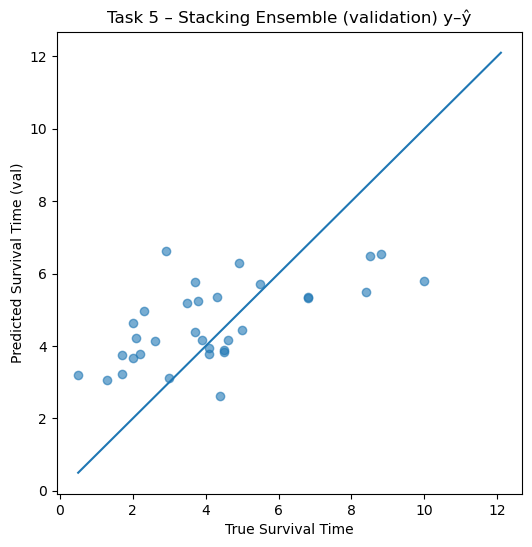


Training final stacking ensemble on ALL supervised data...

Task 5 stacking ensemble submission saved to: ../outputs/csv/optional-submission-06.csv
Submete este ficheiro como: optional-submission-06.csv no Kaggle.


In [34]:
# ================================================
# Task 5 – Stacking Ensemble (sklearn only)
# Gera: optional-submission-06.csv
# ================================================
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.impute import SimpleImputer
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor
)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import StackingRegressor

print("\n==================== Task 5 – Stacking Ensemble ====================\n")

# ------------------------------------------------------------
# 0. Safety checks / fallbacks
# ------------------------------------------------------------

# full_feature_cols (same as in Tasks 3/4)
if "full_feature_cols" not in globals():
    full_feature_cols = [
        "Age", "Gender", "Stage", "GeneticRisk",
        "TreatmentType", "ComorbidityIndex", "TreatmentResponse"
    ]
    print("Warning: full_feature_cols was not defined. Using default list.")

# best_imputer from Task 3.1 (if not available, use median)
if "best_imputer" not in globals():
    print("Warning: best_imputer not found. Using SimpleImputer(strategy='median') as fallback.")
    best_imputer = SimpleImputer(strategy="median")

# 'train' and 'test' should already be loaded as in previous tasks
if "train" not in globals() or "test" not in globals():
    raise RuntimeError("Variables 'train' and 'test' must be defined (CSVs already loaded).")

# ------------------------------------------------------------
# 1. Supervised dataset for Task 5
#    (Censored == 0 and SurvivalTime not NaN)
# ------------------------------------------------------------
supervised_mask_5 = (train["Censored"] == 0) & train["SurvivalTime"].notna()
train_5 = train.loc[supervised_mask_5].copy()

X_5_raw = train_5[full_feature_cols].values
y_5 = train_5["SurvivalTime"].values

print("Total supervised rows (Task 5):", X_5_raw.shape[0])

# Impute using the best imputer from Task 3.1
X_5_imp = best_imputer.fit_transform(X_5_raw)

# Hold-out split for local validation
X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(
    X_5_imp, y_5, test_size=0.2, random_state=42
)

print("Train size (Task 5):", len(X_train_5))
print("Val size   (Task 5):", len(X_val_5))

# ------------------------------------------------------------
# 2. Define base models and stacking ensemble
# ------------------------------------------------------------

# Base learners
base_estimators = [
    ("lin", LinearRegression()),
    ("rf", RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42
    )),
    ("et", ExtraTreesRegressor(
        n_estimators=600,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42
    )),
    ("hgb", HistGradientBoostingRegressor(
        max_iter=400,
        learning_rate=0.05,
        max_depth=None,
        l2_regularization=0.0,
        random_state=42
    )),
]

# Meta-model (on top of base model predictions)
final_estimator = Ridge(alpha=1.0, random_state=42)

stack_model = StackingRegressor(
    estimators=base_estimators,
    final_estimator=final_estimator,
    passthrough=False,  # only use base model predictions, not raw X, in meta-model
    n_jobs=-1
)

# ------------------------------------------------------------
# 3. Train and evaluate on validation split
# ------------------------------------------------------------
print("\nTraining stacking ensemble on train split and evaluating on validation split...")

stack_model.fit(X_train_5, y_train_5)
y_val_pred = stack_model.predict(X_val_5)

mse_val = mean_squared_error(y_val_5, y_val_pred)
rmse_val = np.sqrt(mse_val)

print(f"\nStacking ensemble – validation MSE:  {mse_val:.4f}")
print(f"Stacking ensemble – validation RMSE: {rmse_val:.4f}")

# Optional: y–ŷ plot for your report
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_val_5, y_val_pred, alpha=0.6)
min_y, max_y = y_5.min(), y_5.max()
plt.plot([min_y, max_y], [min_y, max_y])
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time (val)")
plt.title("Task 5 – Stacking Ensemble (validation) y–ŷ")
plt.show()

# ------------------------------------------------------------
# 4. Train final model on ALL supervised data
# ------------------------------------------------------------
print("\nTraining final stacking ensemble on ALL supervised data...")

# Refit imputer on all supervised rows
X_5_imp_all = best_imputer.fit_transform(X_5_raw)

stack_model_final = StackingRegressor(
    estimators=base_estimators,
    final_estimator=final_estimator,
    passthrough=False,
    n_jobs=-1
)

stack_model_final.fit(X_5_imp_all, y_5)

# ------------------------------------------------------------
# 5. Predict on test set and build Kaggle submission
# ------------------------------------------------------------
X_test_raw_5 = test[full_feature_cols].values
X_test_imp_5 = best_imputer.transform(X_test_raw_5)

y_test_pred_5 = stack_model_final.predict(X_test_imp_5)

# Ensure output directory exists
os.makedirs("../outputs/csv", exist_ok=True)

sub_opt_6 = pd.DataFrame({
    "id": test["id"],
    "0": y_test_pred_5
})

output_path_5_stack = "../outputs/csv/optional-submission-06.csv"
sub_opt_6.to_csv(output_path_5_stack, index=False)

print(f"\nTask 5 stacking ensemble submission saved to: {output_path_5_stack}")
print("Submete este ficheiro como: optional-submission-06.csv no Kaggle.")



==================== Task 5 – ULTRA ENSEMBLE (NO LGBM) ====================

Total supervised rows (Task 5): 161
Train size (Task 5): 128
Val size   (Task 5): 33

Training base models on log-target...

Single models – validation RMSE (original scale):
  CatBoost:            RMSE = 1.9322,  MSE = 3.7333
  XGBoost:             RMSE = 1.8951,  MSE = 3.5914
  HistGradientBoosting: RMSE = 1.9667,  MSE = 3.8679

Searching best weights for ensemble (w_cat, w_xgb, w_hgb)...

Best ensemble weights (w_cat, w_xgb, w_hgb): (np.float64(0.30000000000000004), np.float64(0.6000000000000001), np.float64(0.09999999999999987))
Ultra Ensemble – Validation RMSE: 1.8816
Ultra Ensemble – Validation MSE:  3.5406


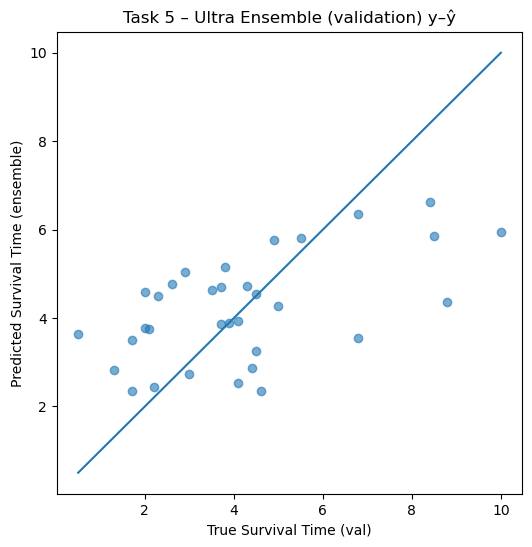


Training final models on ALL supervised data with best weights...

Task 5 Ultra Ensemble submission saved to: ../outputs/csv/optional-submission-08.csv
Sobe ao Kaggle como: optional-submission-08.csv


In [37]:
# ================================================
# Task 5 – Ultra Ensemble (CatBoost + XGB + HGB)
# Produz: optional-submission-08.csv
# ================================================
import numpy as np
import pandas as pd
import os

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

print("\n==================== Task 5 – ULTRA ENSEMBLE (NO LGBM) ====================\n")

# ---------------------------
# 1. Features + Dataset
# ---------------------------
# Safety: full_feature_cols
if "full_feature_cols" not in globals():
    full_feature_cols = [
        "Age", "Gender", "Stage", "GeneticRisk",
        "TreatmentType", "ComorbidityIndex", "TreatmentResponse"
    ]
    print("Warning: full_feature_cols was not defined. Using default list.")

# Safety: best_imputer
if "best_imputer" not in globals():
    print("Warning: best_imputer not found. Using SimpleImputer(strategy='median') as fallback.")
    best_imputer = SimpleImputer(strategy="median")

# Safety: train / test
if "train" not in globals() or "test" not in globals():
    raise RuntimeError("Variables 'train' and 'test' must exist (CSVs already loaded).")

# Supervised dataset: Censored == 0 and SurvivalTime not NaN
supervised_mask = (train["Censored"] == 0) & train["SurvivalTime"].notna()
train_5 = train.loc[supervised_mask].copy()

X_raw = train_5[full_feature_cols].values
y_raw = train_5["SurvivalTime"].values

print("Total supervised rows (Task 5):", X_raw.shape[0])

# Impute + log-target
X_imp = best_imputer.fit_transform(X_raw)
y_log = np.log1p(y_raw)   # log(1 + y)

# Hold-out validation to estimate RMSE
X_train, X_val, y_train, y_val = train_test_split(
    X_imp, y_log, test_size=0.2, random_state=42
)

print("Train size (Task 5):", len(X_train))
print("Val size   (Task 5):", len(X_val))

# ---------------------------
# 2. Modelos base
# ---------------------------

# CatBoost – normalmente muito forte para dados tabulares
cat = CatBoostRegressor(
    loss_function="RMSE",
    depth=6,
    learning_rate=0.03,
    n_estimators=1300,
    subsample=0.9,
    l2_leaf_reg=5.0,
    random_seed=42,
    verbose=False
)

# XGBoost – outra árvore de boosting
xgb = XGBRegressor(
    objective="reg:squarederror",
    max_depth=4,
    learning_rate=0.05,
    n_estimators=800,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
)

# HistGradientBoosting – versão sklearn de gradient boosting
hgb = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_iter=400,
    max_depth=None,
    l2_regularization=0.5,
    random_state=42
)

# ---------------------------
# 3. Treinar modelos individuais
# ---------------------------
print("\nTraining base models on log-target...")

cat.fit(X_train, y_train)
xgb.fit(X_train, y_train)
hgb.fit(X_train, y_train)

pred_cat_val = cat.predict(X_val)
pred_xgb_val = xgb.predict(X_val)
pred_hgb_val = hgb.predict(X_val)

# RMSE individual (escala original)
def rmse_original(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse), mse

rmse_cat, mse_cat = rmse_original(y_val, pred_cat_val)
rmse_xgb, mse_xgb = rmse_original(y_val, pred_xgb_val)
rmse_hgb, mse_hgb = rmse_original(y_val, pred_hgb_val)

print(f"\nSingle models – validation RMSE (original scale):")
print(f"  CatBoost:            RMSE = {rmse_cat:.4f},  MSE = {mse_cat:.4f}")
print(f"  XGBoost:             RMSE = {rmse_xgb:.4f},  MSE = {mse_xgb:.4f}")
print(f"  HistGradientBoosting: RMSE = {rmse_hgb:.4f},  MSE = {mse_hgb:.4f}")

# ---------------------------
# 4. Ensemble por média ponderada (pesos otimizados)
# ---------------------------
print("\nSearching best weights for ensemble (w_cat, w_xgb, w_hgb)...")

best_rmse = np.inf
best_mse = np.inf
best_weights = None

# Grid simples de pesos com passo 0.1
grid = np.arange(0.0, 1.01, 0.1)

for w_cat in grid:
    for w_xgb in grid:
        w_hgb = 1.0 - w_cat - w_xgb
        # garantir que é uma combinação válida
        if w_hgb < 0 or w_hgb > 1:
            continue

        y_ens_log = (
            w_cat * pred_cat_val +
            w_xgb * pred_xgb_val +
            w_hgb * pred_hgb_val
        )

        y_true = np.expm1(y_val)
        y_pred = np.expm1(y_ens_log)

        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)

        if rmse < best_rmse:
            best_rmse = rmse
            best_mse = mse
            best_weights = (w_cat, w_xgb, w_hgb)

print(f"\nBest ensemble weights (w_cat, w_xgb, w_hgb): {best_weights}")
print(f"Ultra Ensemble – Validation RMSE: {best_rmse:.4f}")
print(f"Ultra Ensemble – Validation MSE:  {best_mse:.4f}")

# ---------------------------
# 5. y–ŷ plot do ensemble no validation set
# ---------------------------
import matplotlib.pyplot as plt

w_cat, w_xgb, w_hgb = best_weights

y_ens_val_log = (
    w_cat * pred_cat_val +
    w_xgb * pred_xgb_val +
    w_hgb * pred_hgb_val
)
y_ens_val = np.expm1(y_ens_val_log)
y_val_true = np.expm1(y_val)

plt.figure(figsize=(6, 6))
plt.scatter(y_val_true, y_ens_val, alpha=0.6)
mmin, mmax = y_val_true.min(), y_val_true.max()
plt.plot([mmin, mmax], [mmin, mmax])
plt.xlabel("True Survival Time (val)")
plt.ylabel("Predicted Survival Time (ensemble)")
plt.title("Task 5 – Ultra Ensemble (validation) y–ŷ")
plt.show()

# ---------------------------
# 6. Treinar em TODOS os dados supervisionados
# ---------------------------
print("\nTraining final models on ALL supervised data with best weights...")

# Reimputar com todos os supervisionados
X_imp_all = best_imputer.fit_transform(X_raw)
y_log_all = np.log1p(y_raw)

cat.fit(X_imp_all, y_log_all)
xgb.fit(X_imp_all, y_log_all)
hgb.fit(X_imp_all, y_log_all)

# ---------------------------
# 7. Prever Test e gerar Kaggle CSV
# ---------------------------
X_test_raw = test[full_feature_cols].values
X_test_imp = best_imputer.transform(X_test_raw)

t_cat_log = cat.predict(X_test_imp)
t_xgb_log = xgb.predict(X_test_imp)
t_hgb_log = hgb.predict(X_test_imp)

test_pred_log = (
    w_cat * t_cat_log +
    w_xgb * t_xgb_log +
    w_hgb * t_hgb_log
)

test_pred = np.expm1(test_pred_log)

os.makedirs("../outputs/csv", exist_ok=True)

sub = pd.DataFrame({
    "id": test["id"],
    "0": test_pred
})

output_path = "../outputs/csv/optional-submission-08.csv"
sub.to_csv(output_path, index=False)

print(f"\nTask 5 Ultra Ensemble submission saved to: {output_path}")
print("Sobe ao Kaggle como: optional-submission-08.csv")


In [39]:
# ================================================
# Task 5 – CatBoost with K-Fold CV (no log-target)
# Produces: optional-submission-09.csv
# ================================================
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

from catboost import CatBoostRegressor

print("\n==================== Task 5 – CatBoost + K-Fold CV ====================\n")

# ------------------------------------------------------------
# 0. Safety checks / fallbacks
# ------------------------------------------------------------
if "full_feature_cols" not in globals():
    full_feature_cols = [
        "Age", "Gender", "Stage", "GeneticRisk",
        "TreatmentType", "ComorbidityIndex", "TreatmentResponse"
    ]
    print("Warning: full_feature_cols was not defined. Using default list.")

if "best_imputer" not in globals():
    print("Warning: best_imputer not found. Using SimpleImputer(strategy='median') as fallback.")
    best_imputer = SimpleImputer(strategy="median")

if "train" not in globals() or "test" not in globals():
    raise RuntimeError("Variables 'train' and 'test' must be loaded before Task 5.")

# ------------------------------------------------------------
# 1. Supervised dataset: uncensored with known SurvivalTime
# ------------------------------------------------------------
mask_sup = (train["Censored"] == 0) & train["SurvivalTime"].notna()
train_5 = train.loc[mask_sup].copy()

X_raw = train_5[full_feature_cols].values
y_raw = train_5["SurvivalTime"].values

print("Total supervised rows (Task 5):", X_raw.shape[0])

# Impute features -> tudo fica float, por isso NÃO usamos cat_features no CatBoost
X_imp = best_imputer.fit_transform(X_raw)

# Pequeno hold-out só para sanity check no fim
X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(
    X_imp, y_raw, test_size=0.2, random_state=42
)

print("Train size (hold-out view):", len(X_train_all))
print("Val size   (hold-out view):", len(X_val_all))

# ------------------------------------------------------------
# 2. Hyperparameter grid for CatBoost (original target, sem log)
# ------------------------------------------------------------
param_grid = [
    {"depth": 4, "learning_rate": 0.03, "n_estimators": 700, "l2_leaf_reg": 3.0, "subsample": 0.9},
    {"depth": 6, "learning_rate": 0.03, "n_estimators": 800, "l2_leaf_reg": 3.0, "subsample": 0.9},
    {"depth": 6, "learning_rate": 0.05, "n_estimators": 700, "l2_leaf_reg": 5.0, "subsample": 0.9},
    {"depth": 8, "learning_rate": 0.03, "n_estimators": 900, "l2_leaf_reg": 5.0, "subsample": 0.8},
]

# ------------------------------------------------------------
# 3. K-Fold CV to choose best hyperparameters
# ------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_cv_rmse = np.inf
best_params = None

for i, p in enumerate(param_grid, start=1):
    print(f"\n=== Config {i}/{len(param_grid)}: {p} ===")
    fold_rmses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_imp), start=1):
        X_tr, X_va = X_imp[train_idx], X_imp[val_idx]
        y_tr, y_va = y_raw[train_idx], y_raw[val_idx]

        model_cb = CatBoostRegressor(
            loss_function="RMSE",
            depth=p["depth"],
            learning_rate=p["learning_rate"],
            n_estimators=p["n_estimators"],
            l2_leaf_reg=p["l2_leaf_reg"],
            subsample=p["subsample"],
            random_seed=42,
            verbose=False
        )

        # ATENÇÃO: aqui NÃO passamos cat_features
        model_cb.fit(
            X_tr, y_tr,
            eval_set=(X_va, y_va),
            verbose=False
        )

        y_va_pred = model_cb.predict(X_va)
        mse_va = mean_squared_error(y_va, y_va_pred)
        rmse_va = np.sqrt(mse_va)
        fold_rmses.append(rmse_va)

        print(f"  Fold {fold}: RMSE = {rmse_va:.4f}")

    mean_rmse = np.mean(fold_rmses)
    std_rmse = np.std(fold_rmses)
    print(f"  -> Mean CV RMSE = {mean_rmse:.4f} (± {std_rmse:.4f})")

    if mean_rmse < best_cv_rmse:
        best_cv_rmse = mean_rmse
        best_params = p

print("\nBest CatBoost params from CV:")
print(best_params)
print(f"Best mean CV RMSE: {best_cv_rmse:.4f}")

# ------------------------------------------------------------
# 4. Train final CatBoost on ALL supervised data with best params
# ------------------------------------------------------------
print("\nTraining final CatBoost on ALL supervised data...")

final_cb = CatBoostRegressor(
    loss_function="RMSE",
    depth=best_params["depth"],
    learning_rate=best_params["learning_rate"],
    n_estimators=best_params["n_estimators"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    subsample=best_params["subsample"],
    random_seed=42,
    verbose=False
)

final_cb.fit(
    X_imp, y_raw,
    verbose=False
)

# Quick hold-out sanity check
y_val_pred_all = final_cb.predict(X_val_all)
mse_val_all = mean_squared_error(y_val_all, y_val_pred_all)
rmse_val_all = np.sqrt(mse_val_all)

print("\n[Hold-out sanity check]")
print(f"Final CatBoost – hold-out RMSE: {rmse_val_all:.4f}")
print(f"Final CatBoost – hold-out MSE:  {mse_val_all:.4f}")

# ------------------------------------------------------------
# 5. Predict on test set and save Kaggle submission
# ------------------------------------------------------------
X_test_raw = test[full_feature_cols].values
X_test_imp = best_imputer.transform(X_test_raw)

test_pred = final_cb.predict(X_test_imp)

os.makedirs("../outputs/csv", exist_ok=True)

sub_09 = pd.DataFrame({
    "id": test["id"],
    "0": test_pred
})

output_path_09 = "../outputs/csv/optional-submission-09.csv"
sub_09.to_csv(output_path_09, index=False)

print(f"\nTask 5 CatBoost CV submission saved to: {output_path_09}")
print("Upload as: optional-submission-09.csv")



==================== Task 5 – CatBoost + K-Fold CV ====================

Total supervised rows (Task 5): 161
Train size (hold-out view): 128
Val size   (hold-out view): 33

=== Config 1/4: {'depth': 4, 'learning_rate': 0.03, 'n_estimators': 700, 'l2_leaf_reg': 3.0, 'subsample': 0.9} ===
  Fold 1: RMSE = 1.8457
  Fold 2: RMSE = 1.8376
  Fold 3: RMSE = 1.4844
  Fold 4: RMSE = 2.0252
  Fold 5: RMSE = 1.8346
  -> Mean CV RMSE = 1.8055 (± 0.1760)

=== Config 2/4: {'depth': 6, 'learning_rate': 0.03, 'n_estimators': 800, 'l2_leaf_reg': 3.0, 'subsample': 0.9} ===
  Fold 1: RMSE = 1.8836
  Fold 2: RMSE = 1.8509
  Fold 3: RMSE = 1.4906
  Fold 4: RMSE = 2.0398
  Fold 5: RMSE = 1.8218
  -> Mean CV RMSE = 1.8173 (± 0.1799)

=== Config 3/4: {'depth': 6, 'learning_rate': 0.05, 'n_estimators': 700, 'l2_leaf_reg': 5.0, 'subsample': 0.9} ===
  Fold 1: RMSE = 1.8513
  Fold 2: RMSE = 1.8587
  Fold 3: RMSE = 1.5022
  Fold 4: RMSE = 2.0583
  Fold 5: RMSE = 1.8282
  -> Mean CV RMSE = 1.8198 (± 0.1791)

=== 